In [ ]:
import os
os.environ.setdefault("XLA_PYTHON_CLIENT_PREALLOCATE", "false")

from dataclasses import dataclass, replace
from typing import Any, Callable, Dict, Iterable, Iterator, Optional, Tuple
from typing import List

import jax
import jax.numpy as jnp
from jax import lax, random

import numpy as np
from functools import partial

import flax.linen as nn
import optax

from tqdm import tqdm


import jax
from jax import random

USE_GPU: bool = True

def _devices_safe(backend: str):
    """Return devices for 'backend' or [] if unavailable (no exceptions)."""
    try:
        return jax.devices(backend)
    except Exception:
        return []

if USE_GPU:
    devs = []
    for backend in ("cuda", "gpu", "rocm"):
        devs = _devices_safe(backend)
        if devs:
            break
    SELECTED_DEVICE = devs[0] if devs else jax.devices("cpu")[0]
else:
    SELECTED_DEVICE = jax.devices("cpu")[0]

print("Selected device:", SELECTED_DEVICE, "| platform:", getattr(SELECTED_DEVICE, "platform", "?"))

def on_device(x):
    return jax.device_put(x, device=SELECTED_DEVICE)

def key_splitter(seed: int = 0):
    key = random.PRNGKey(seed)
    while True:
        key, sub = random.split(key)
        yield sub

IS_ACCELERATOR = getattr(SELECTED_DEVICE, "platform", "cpu") in ("gpu", "cuda", "rocm", "tpu")


Selected device: cuda:0 | platform: gpu


In [2]:
from flax import linen as nn
import jax, jax.numpy as jnp

class Tiny(nn.Module):
    @nn.compact
    def __call__(self, x):
        return nn.relu(nn.Dense(8)(x))

dummy = jnp.ones((1, 4), dtype=jnp.float32)
vars_tiny = Tiny().init(jax.random.key(0), dummy)  # should not raise
print("Tiny init OK:", all(k in vars_tiny for k in ("params",)))


import jax, jaxlib, flax, optax, chex
print("jax:", jax.__version__, "jaxlib:", jaxlib.__version__,
      "flax:", flax.__version__, "optax:", optax.__version__, "chex:", chex.__version__)
print("devices:", jax.devices(), "| backend:", jax.default_backend())

import jax, jaxlib
print("jax:", jax.__version__, "jaxlib:", jaxlib.__version__)
print("devices:", jax.devices())
print("default backend:", jax.default_backend())


Tiny init OK: True
jax: 0.7.2 jaxlib: 0.7.2 flax: 0.12.0 optax: 0.2.6 chex: 0.1.91
devices: [CudaDevice(id=0)] | backend: gpu
jax: 0.7.2 jaxlib: 0.7.2
devices: [CudaDevice(id=0)]
default backend: gpu


In [ ]:

import os, sys, json, math, gzip, time, pathlib, urllib.request
from dataclasses import dataclass, replace
from typing import Tuple, Optional, Iterator, Dict, Any

os.environ.setdefault("XLA_PYTHON_CLIENT_PREALLOCATE", "false")

import jax
import jax.numpy as jnp
from jax import random, lax

import numpy as np
import optax
import flax
import flax.linen as nn
from tqdm import tqdm

print("JAX:", jax.__version__, "| Flax:", flax.__version__, "| Optax:", optax.__version__)
print("Devices:", jax.devices(), "| Default backend:", jax.default_backend())

def split_key(seed: int = 0):
    key = random.PRNGKey(seed)
    while True:
        key, sub = random.split(key)
        yield sub


JAX: 0.7.2 | Flax: 0.12.0 | Optax: 0.2.6
Devices: [CudaDevice(id=0)] | Default backend: gpu


In [ ]:

@dataclass
class HRMConfig:
    # 
    dataset_name: str = "mnist"
    image_shape: Tuple[int, int, int] = (28, 28, 1)
    num_classes: int = 10

    # tokenization
    patch_size: int = 4                 # 28x28 -> 7x7 grid + [CLS]
    d_model: int = 128
    num_heads: int = 4
    mlp_mult: int = 4                   # FFN hidden = mlp_mult * d_model
    num_layers_L: int = 2               # depth inside f_L (Transformer encoder)
    num_layers_H: int = 2               # depth inside f_H

    # recurrent schedule
    num_high_cycles: int = 2            # N
    num_low_steps_per_cycle: int = 3    # T

    # deep supervision
    num_segments_train: int = 2         # M, segments per batch during training
    num_segments_eval: int = 2          # segments during evaluation

    # ACT 
    use_act_train: bool = False
    act_lambda: float = 0.1             # weight on Q-loss if enabled
    act_epsilon: float = 0.2            # exploration for min segments (see paper)
    act_max_segments: int = 4           # M_max for training/inference

    # optimizer
    learning_rate: float = 1e-3
    weight_decay: float = 1e-4
    batch_size: int = 128
    num_epochs: int = 3
    seed: int = 42

cfg = HRMConfig()


In [ ]:

DATA_DIR = pathlib.Path("./data").resolve()
DATA_DIR.mkdir(parents=True, exist_ok=True)

MNIST_FILES = {
    "train_images": "train-images-idx3-ubyte.gz",
    "train_labels": "train-labels-idx1-ubyte.gz",
    "test_images":  "t10k-images-idx3-ubyte.gz",
    "test_labels":  "t10k-labels-idx1-ubyte.gz",
}
MNIST_MIRRORS = [
    "https://storage.googleapis.com/cvdf-datasets/mnist",
    "https://ossci-datasets.s3.amazonaws.com/mnist",
    "http://yann.lecun.com/exdb/mnist",
]

def _is_valid_mnist_gz(path: pathlib.Path, kind: str) -> bool:
    if not path.exists() or path.stat().st_size < 64:
        return False
    try:
        with gzip.open(path, "rb") as f:
            head = f.read(16 if "images" in kind else 8)
        magic = int.from_bytes(head[0:4], "big")
        return (magic == 2051) if ("images" in kind) else (magic == 2049)
    except Exception:
        return False

def _download_with_retries(url: str, dest: pathlib.Path, retries: int = 3, delay: float = 1.0):
    last_err = None
    for k in range(1, retries + 1):
        try:
            urllib.request.urlretrieve(url, dest)
            return
        except Exception as e:
            last_err = e; time.sleep(delay * k)
    raise RuntimeError(f"Failed to download {url}: {last_err}")

def _ensure_file(kind: str, filename: str) -> pathlib.Path:
    dest = DATA_DIR / filename
    if dest.exists() and not _is_valid_mnist_gz(dest, kind):
        try: dest.unlink()
        except Exception: pass
    if not dest.exists():
        for base in MNIST_MIRRORS:
            url = f"{base}/{filename}"
            try:
                _download_with_retries(url, dest)
                if _is_valid_mnist_gz(dest, kind): break
                else: dest.unlink(missing_ok=True)
            except Exception:
                dest.unlink(missing_ok=True); continue
        else:
            raise RuntimeError(f"Could not fetch {filename} from any mirror.")
    if not _is_valid_mnist_gz(dest, kind):
        raise RuntimeError(f"Downloaded {filename} but validation failed.")
    return dest

def _read_idx_images(path: pathlib.Path) -> np.ndarray:
    with gzip.open(path, "rb") as f: data = f.read()
    magic, n, rows, cols = np.frombuffer(data[:16], dtype=">i4")
    assert magic == 2051
    imgs = np.frombuffer(data[16:], dtype=np.uint8).reshape(n, rows, cols, 1)
    return imgs

def _read_idx_labels(path: pathlib.Path) -> np.ndarray:
    with gzip.open(path, "rb") as f: data = f.read()
    magic, n = np.frombuffer(data[:8], dtype=">i4")
    assert magic == 2049
    return np.frombuffer(data[8:], dtype=np.uint8)

def load_mnist() -> Tuple[Tuple[np.ndarray, np.ndarray], Tuple[np.ndarray, np.ndarray]]:
    paths = {k: _ensure_file(k, v) for k, v in MNIST_FILES.items()}
    x_train = _read_idx_images(paths["train_images"]).astype(np.float32) / 255.0
    y_train = _read_idx_labels(paths["train_labels"]).astype(np.int32)
    x_test  = _read_idx_images(paths["test_images"]).astype(np.float32)  / 255.0
    y_test  = _read_idx_labels(paths["test_labels"]).astype(np.int32)
    return (x_train, y_train), (x_test, y_test)

def standardize(x: np.ndarray, mean: Optional[float]=None, std: Optional[float]=None):
    if mean is None: mean = float(x.mean())
    if std  is None: std  = float(x.std() + 1e-6)
    return (x - mean) / std, (mean, std)


In [ ]:

def batch_iterator(x: np.ndarray, y: np.ndarray, batch_size: int, shuffle: bool, seed: int) -> Iterator[Tuple[jnp.ndarray, jnp.ndarray]]:
    n = x.shape[0]
    idx = np.arange(n)
    rng = np.random.default_rng(seed)
    if shuffle: rng.shuffle(idx)
    for s in range(0, n, batch_size):
        e = min(s + batch_size, n)
        sel = idx[s:e]
        yield jnp.asarray(x[sel]), jnp.asarray(y[sel])


In [ ]:

class RMSNorm(nn.Module):
    features: int
    eps: float = 1e-6
    @nn.compact
    def __call__(self, x):
        scale = self.param("scale", nn.initializers.ones, (self.features,))
        rms = jnp.sqrt(jnp.mean(jnp.square(x), axis=-1, keepdims=True) + self.eps)
        return (x / rms) * scale  # no bias, post-norm

# --- RoPE helpers (single, correct version) ---

def rope_frequencies(seq_len: int, head_dim: int, base: float = 10000.0):
    """
    Return cos, sin with shape [S, Dh//2] suitable for pair-wise rotation.
    """
    assert head_dim % 2 == 0, "Per-head dim must be even for RoPE."
    half = head_dim // 2
    inv_freq = 1.0 / (base ** (jnp.arange(0, half, dtype=jnp.float32) / half))
    t = jnp.arange(seq_len, dtype=jnp.float32)
    freqs = jnp.einsum("s,d->sd", t, inv_freq)   # [S, Dh//2]
    cos = jnp.cos(freqs)                          # [S, Dh//2]
    sin = jnp.sin(freqs)                          # [S, Dh//2]
    return cos, sin

def apply_rope(x, cos, sin):
    """
    x:   [B, S, H, Dh] with Dh even (pair-wise rotation).
    cos: [S, Dh//2]
    sin: [S, Dh//2]
    """
    B, S, H, Dh = x.shape
    half = Dh // 2
    x = x.reshape(B, S, H, half, 2)          # pairwise
    x1 = x[..., 0]                            # [B,S,H,half]
    x2 = x[..., 1]                            # [B,S,H,half]
    cos_b = cos[None, :, None, :]             # [1,S,1,half]
    sin_b = sin[None, :, None, :]             # [1,S,1,half]
    x1_rot = x1 * cos_b - x2 * sin_b
    x2_rot = x1 * sin_b + x2 * cos_b
    out = jnp.stack([x1_rot, x2_rot], axis=-1).reshape(B, S, H, Dh)
    return out

class SelfAttentionRoPE(nn.Module):
    d_model: int
    num_heads: int
    use_bias: bool = False
    kernel_init: Any = nn.initializers.lecun_normal()

    @nn.compact
    def __call__(self, x):
        B, S, D = x.shape
        H = self.num_heads
        assert D % H == 0, "d_model must be divisible by num_heads"
        Dh = D // H
        assert (Dh % 2) == 0, "Per-head dim must be even for RoPE."

        qkv = nn.Dense(3 * D, use_bias=self.use_bias, kernel_init=self.kernel_init, name="qkv")(x)
        q, k, v = jnp.split(qkv, 3, axis=-1)

        def reshape_heads(t): return t.reshape(B, S, H, Dh)
        q = reshape_heads(q); k = reshape_heads(k); v = reshape_heads(v)

        cos, sin = rope_frequencies(S, Dh)    # returns [S, Dh//2] each
        q = apply_rope(q, cos, sin)
        k = apply_rope(k, cos, sin)

        # attn: [B,H,S,S]
        attn_scores = jnp.einsum("bshd,bthd->bhst", q, k) / jnp.sqrt(Dh)
        attn = nn.softmax(attn_scores, axis=-1)
        out = jnp.einsum("bhst,bthd->bshd", attn, v).reshape(B, S, D)
        out = nn.Dense(D, use_bias=self.use_bias, kernel_init=self.kernel_init, name="proj")(out)
        return out

class GEGLU(nn.Module):
    d_hidden: int
    use_bias: bool = False
    kernel_init: Any = nn.initializers.lecun_normal()
    @nn.compact
    def __call__(self, x):
        u, v = jnp.split(
            nn.Dense(2 * self.d_hidden, use_bias=self.use_bias, kernel_init=self.kernel_init, name="geglu")(x),
            2, axis=-1
        )
        return nn.Dense(x.shape[-1], use_bias=self.use_bias, kernel_init=self.kernel_init, name="out")(nn.gelu(v) * u)

class TransformerEncoderBlock(nn.Module):
    d_model: int
    num_heads: int
    mlp_mult: int
    @nn.compact
    def __call__(self, x):
        # attention
        y = SelfAttentionRoPE(self.d_model, self.num_heads)(x)
        x = x + y
        x = RMSNorm(self.d_model)(x)  # Post-Norm

        # Feed-forward (GEGLU)
        y = GEGLU(self.d_model * self.mlp_mult)(x)
        x = x + y
        x = RMSNorm(self.d_model)(x)  # Post-Norm
        return x

class TransformerEncoder(nn.Module):
    d_model: int
    num_heads: int
    mlp_mult: int
    num_layers: int
    @nn.compact
    def __call__(self, x):
        for _ in range(self.num_layers):
            x = TransformerEncoderBlock(self.d_model, self.num_heads, self.mlp_mult)(x)
        return x


In [ ]:

class PatchEmbed(nn.Module):
    patch_size: int
    d_model: int
    use_bias: bool = False
    kernel_init: Any = nn.initializers.lecun_normal()
    @nn.compact
    def __call__(self, images):  # images [B,H,W,C]
        B, H, W, C = images.shape
        P = self.patch_size
        assert H % P == 0 and W % P == 0
        gh, gw = H // P, W // P
        # to (B, gh, gw, P, P, C) -> (B, gh*gw, P*P*C)
        patches = images.reshape(B, gh, P, gw, P, C).transpose(0,1,3,2,4,5).reshape(B, gh*gw, P*P*C)
        x = nn.Dense(self.d_model, use_bias=self.use_bias, kernel_init=self.kernel_init, name="proj")(patches)
        # prepend [CLS]
        cls = self.param("cls", nn.initializers.lecun_normal(), (1, 1, self.d_model))
        cls_b = jnp.tile(cls, (B, 1, 1))
        return jnp.concatenate([cls_b, x], axis=1)  # [B, 1 + gh*gw, D]

class HRMCore(nn.Module):
    # architectures of the two modules  
    d_model: int
    num_heads: int
    mlp_mult: int
    num_layers_L: int
    num_layers_H: int
    num_classes: int

    patch_size: int

    @nn.compact
    def __call__(self,
                 images: jnp.ndarray,
                 z_pair: Tuple[jnp.ndarray, jnp.ndarray],
                 num_high_cycles: int,
                 num_low_steps_per_cycle: int,
                 training: bool = True,
                 return_q: bool = False):
        """
        One 'segment' forward pass with 1-step gradient:
          - All but the last low-level/high-level updates run under stop_gradient.
          - Last low update + last high update allow gradient to flow to params.
        Returns new (zH, zL) and logits (and optionally Q values).
        """
        # fI: tokenization
        x_tilde = PatchEmbed(self.patch_size, self.d_model)(images)  # [B,S,D]
        zH, zL = z_pair  # both [B,S,D]

        fL = TransformerEncoder(self.d_model, self.num_heads, self.mlp_mult, self.num_layers_L)
        fH = TransformerEncoder(self.d_model, self.num_heads, self.mlp_mult, self.num_layers_H)

        # recurrent dynamics with hierarchical convergence
        total_steps = num_high_cycles * num_low_steps_per_cycle

        # all but last step without gradient (equivalent to torch.no_grad block)
        for i in range(total_steps - 1):
            # L-step
            zL = fL(zL + zH + x_tilde)   # element-wise merge of inputs, then Transformer 
            # H-step at cycle boundary
            if (i + 1) % num_low_steps_per_cycle == 0:
                zH = fH(zH + zL)
            zH = lax.stop_gradient(zH)
            zL = lax.stop_gradient(zL)

        # final step WITH gradient (1-step approximation)
        zL = fL(zL + zH + x_tilde)
        zH = fH(zH + zL)

        # output head on H-module (p.9: f_O(z_H) = softmax(W z_H))
        cls = zH[:, 0, :]  # [B,D]
        logits = nn.Dense(self.num_classes, use_bias=False, kernel_init=nn.initializers.lecun_normal(), name="logits")(cls)

        if return_q:
            q = nn.sigmoid(nn.Dense(2, use_bias=False, kernel_init=nn.initializers.lecun_normal(), name="q_head")(cls))  # (halt, continue)
            return (zH, zL), logits, q
        else:
            return (zH, zL), logits


In [ ]:

def truncated_normal(key, shape, std: float = 1.0, trunc: float = 2.0):
    return std * random.truncated_normal(key, lower=-trunc, upper=trunc, shape=shape)

def compute_seq_len(image_shape: Tuple[int,int,int], patch_size: int) -> int:
    h, w, _ = image_shape
    return 1 + (h // patch_size) * (w // patch_size)  # +1 for [CLS]

def make_initial_states_template(cfg: HRMConfig, key: jax.Array):
    S = compute_seq_len(cfg.image_shape, cfg.patch_size)
    z0H = truncated_normal(key,  (1, S, cfg.d_model), std=1.0, trunc=2.0)
    z0L = truncated_normal(next(split_key(cfg.seed+1)), (1, S, cfg.d_model), std=1.0, trunc=2.0)
    return z0H, z0L

def tile_state(z_template: jnp.ndarray, batch: int) -> jnp.ndarray:
    return jnp.tile(z_template, (batch, 1, 1))

def cross_entropy_loss(logits: jnp.ndarray, labels: jnp.ndarray) -> jnp.ndarray:
    return optax.softmax_cross_entropy_with_integer_labels(logits, labels).mean()

def accuracy(logits: jnp.ndarray, labels: jnp.ndarray) -> jnp.ndarray:
    return (jnp.argmax(logits, axis=-1) == labels).mean()


In [ ]:

def make_optimizer(cfg: HRMConfig, steps_per_epoch: int):
    schedule = optax.cosine_decay_schedule(init_value=cfg.learning_rate,
                                           decay_steps=steps_per_epoch * cfg.num_epochs)
    tx = optax.chain(
        optax.clip_by_global_norm(1.0),
        optax.adamw(learning_rate=schedule, weight_decay=cfg.weight_decay),
    )
    return tx

keygen = split_key(cfg.seed)
rng0 = next(keygen)

# image to initialize shapes
dummy = jnp.zeros((1,) + cfg.image_shape, dtype=jnp.float32)
model = HRMCore(cfg.d_model, cfg.num_heads, cfg.mlp_mult, cfg.num_layers_L, cfg.num_layers_H,
                cfg.num_classes, cfg.patch_size)

variables = model.init(rng0, dummy,
                       (truncated_normal(next(keygen), (1, compute_seq_len(cfg.image_shape, cfg.patch_size), cfg.d_model)),
                        truncated_normal(next(keygen), (1, compute_seq_len(cfg.image_shape, cfg.patch_size), cfg.d_model))),
                       cfg.num_high_cycles, cfg.num_low_steps_per_cycle, True, False)
params = variables["params"]

def count_params(pytree) -> int:
    return sum(int(np.prod(x.shape)) for x in jax.tree_util.tree_leaves(pytree))

print("Parameter count:", count_params(params))


Parameter count: 1053056


In [ ]:
# %% [code]
from functools import partial as _partial

@_partial(jax.jit, static_argnums=(4, 5))  # indices of the positional static args
def segment_forward_and_loss(
    params,
    images,
    labels,
    z_pair,
    num_high_cycles: int,         
    num_low_steps_per_cycle: int,   
):
    """One deep-supervision segment with 1-step gradient.
       Returns: grads, loss, acc, logits, (detached zH, zL)."""

    def loss_fn(p):
        (z_new, logits) = model.apply(
            {"params": p},
            images,
            z_pair,
            num_high_cycles,
            num_low_steps_per_cycle,
            True,     # training=True
            False,    # return_q=False
        )
        loss = cross_entropy_loss(logits, labels)
        acc  = accuracy(logits, labels)
        return loss, (z_new, logits, acc)

    (loss, (z_new, logits, acc)), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)

    #  carry-over state for next segment 
    zH_new, zL_new = z_new
    z_pair_next = (jax.lax.stop_gradient(zH_new), jax.lax.stop_gradient(zL_new))
    return grads, loss, acc, logits, z_pair_next


def train_one_batch(
    params,
    opt_state,
    images,
    labels,
    z_pair,
    cfg: HRMConfig,
    optimizer,
):
    """Deep supervision: run M segments; update after each; carry detached state forward."""
    seg_losses = []
    seg_accs = []

    for _ in range(cfg.num_segments_train):
        grads, loss, acc, logits, z_pair = segment_forward_and_loss(
            params,
            images,
            labels,
            z_pair,
            cfg.num_high_cycles,            
            cfg.num_low_steps_per_cycle,    
        )
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        seg_losses.append(loss)
        seg_accs.append(acc)

    return params, opt_state, z_pair, (jnp.stack(seg_losses).mean(), jnp.stack(seg_accs).mean())


In [12]:
(x_train, y_train), (x_test, y_test) = load_mnist()
x_train, (m, s) = standardize(x_train)
x_test, _ = standardize(x_test, mean=m, std=s)

In [ ]:

from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np

# 
mpl.rcParams.update({
    "figure.figsize": (3.6, 2.6),
    "figure.dpi": 200,
    "savefig.dpi": 300,
    "font.size": 10,
    "axes.titlesize": 11,
    "axes.labelsize": 10,
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "axes.grid": True,
    "grid.alpha": 0.3,
})
mpl.rcParams['figure.constrained_layout.use'] = True  # let Matplotlib manage margins

#
RUN_NAME = f"mnist_hrm_D{cfg.d_model}_H{cfg.num_high_cycles}_L{cfg.num_low_steps_per_cycle}_seg{cfg.num_segments_train}_seed{cfg.seed}"
RUN_DIR = Path("./results") / RUN_NAME
RUN_DIR.mkdir(parents=True, exist_ok=True)


keygen = split_key(cfg.seed + 123) 
dummy = jnp.zeros((1,) + cfg.image_shape, dtype=jnp.float32)

model = HRMCore(cfg.d_model, cfg.num_heads, cfg.mlp_mult, cfg.num_layers_L, cfg.num_layers_H,
                cfg.num_classes, cfg.patch_size)

variables = model.init(
    next(keygen),
    dummy,
    (truncated_normal(next(keygen), (1, compute_seq_len(cfg.image_shape, cfg.patch_size), cfg.d_model)),
     truncated_normal(next(keygen), (1, compute_seq_len(cfg.image_shape, cfg.patch_size), cfg.d_model))),
    cfg.num_high_cycles, cfg.num_low_steps_per_cycle,
    True, False
)
params = variables["params"]
n_params = sum(int(np.prod(x.shape)) for x in jax.tree_util.tree_leaves(params))
print(f"[Paper run] Parameters: {n_params:,}")

steps_per_epoch = (len(x_train) + cfg.batch_size - 1) // cfg.batch_size
optimizer = make_optimizer(cfg, steps_per_epoch)
opt_state = optimizer.init(params)

#
z0H_t, z0L_t = make_initial_states_template(cfg, next(keygen))

#
step_loss, step_acc = [], []
epoch_rows = []

for epoch in range(1, cfg.num_epochs + 1):
    train_it = batch_iterator(x_train, y_train, cfg.batch_size, shuffle=True, seed=cfg.seed + epoch)
    running_loss = 0.0
    running_acc = 0.0
    nbatch = 0

    for xb, yb in tqdm(train_it, total=steps_per_epoch, desc=f"[Paper] Epoch {epoch}"):
        bsz = xb.shape[0]
        z_pair = (tile_state(z0H_t, bsz), tile_state(z0L_t, bsz))
        params, opt_state, z_pair, (l_mean, a_mean) = train_one_batch(
            params, opt_state, xb, yb, z_pair, cfg, optimizer
        )
        step_loss.append(float(l_mean))
        step_acc.append(float(a_mean))
        running_loss += float(l_mean)
        running_acc += float(a_mean)
        nbatch += 1

    epoch_rows.append({
        "epoch": epoch,
        "train_loss": running_loss / nbatch,
        "train_acc":  running_acc / nbatch
    })
    print(f"[Paper] Epoch {epoch:02d} | train loss {epoch_rows[-1]['train_loss']:.4f} | train acc {epoch_rows[-1]['train_acc']:.4f}")

#
def eval_model(params, x, y, bs):
    test_it = batch_iterator(x, y, bs, shuffle=False, seed=0)
    tot_a = 0.0
    nb = 0
    for xb, yb in test_it:
        bsz = xb.shape[0]
        z_pair = (tile_state(z0H_t, bsz), tile_state(z0L_t, bsz))
        logits = None
        for _ in range(cfg.num_segments_eval):
            (z_pair, logits) = model.apply(
                {"params": params},
                xb, z_pair,
                cfg.num_high_cycles, cfg.num_low_steps_per_cycle,
                False, False
            )
            z_pair = (jax.lax.stop_gradient(z_pair[0]), jax.lax.stop_gradient(z_pair[1]))
        tot_a += float(accuracy(logits, yb))
        nb += 1
    return tot_a / nb

test_acc = eval_model(params, x_test, y_test, cfg.batch_size)
print(f"[Paper run] Test acc {test_acc:.4f}")

#
pd.DataFrame(epoch_rows).to_csv(RUN_DIR / "epoch_metrics.csv", index=False)
np.savez(
    RUN_DIR / "metrics.npz",
    step_loss=np.array(step_loss, np.float32),
    step_acc=np.array(step_acc, np.float32),
    epoch=np.array([r["epoch"] for r in epoch_rows]),
    epoch_loss=np.array([r["train_loss"] for r in epoch_rows], np.float32),
    epoch_acc=np.array([r["train_acc"] for r in epoch_rows], np.float32),
    test_acc=np.float32(test_acc),
    n_params=np.int64(n_params),
)


[Paper run] Parameters: 1,053,056


[Paper] Epoch 1: 100%|██████████| 469/469 [02:05<00:00,  3.73it/s]


[Paper] Epoch 01 | train loss 0.3944 | train acc 0.8705


[Paper] Epoch 2: 100%|██████████| 469/469 [01:48<00:00,  4.32it/s]


[Paper] Epoch 02 | train loss 0.0684 | train acc 0.9791


[Paper] Epoch 3: 100%|██████████| 469/469 [01:53<00:00,  4.15it/s]


[Paper] Epoch 03 | train loss 0.0541 | train acc 0.9840
[Paper run] Test acc 0.9802


/tmp/ipykernel_6080/1517649630.py:16: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


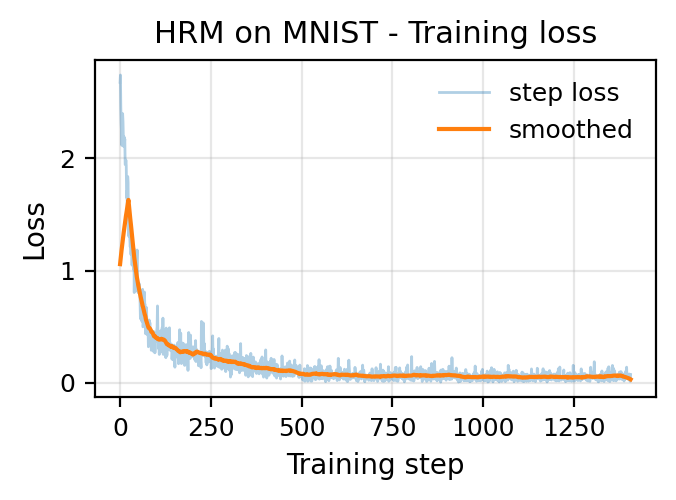

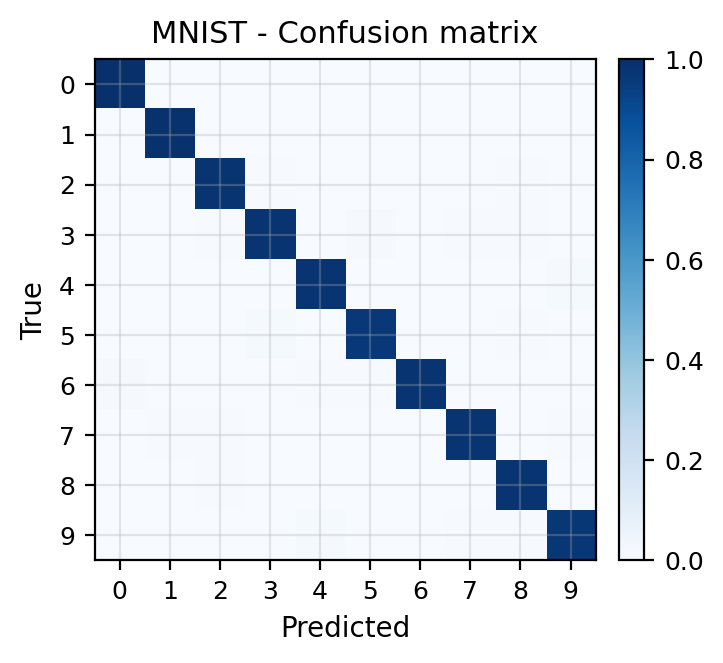

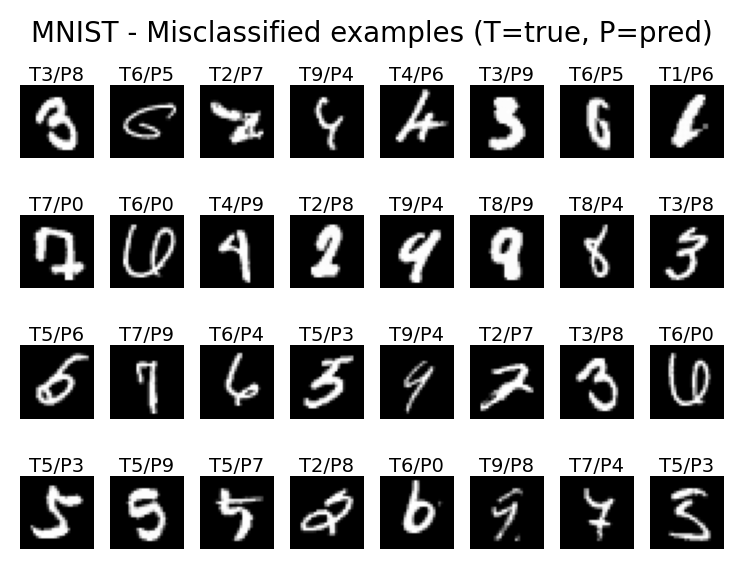

In [ ]:

def smooth(y, k=21):
    if k <= 1 or k > len(y): return y
    w = np.ones(k) / k
    return np.convolve(y, w, mode="same")


plt.figure()
plt.plot(step_loss, lw=1.0, alpha=0.35, label="step loss")
plt.plot(smooth(step_loss, k=max(11, len(step_loss)//30)), lw=1.5, label="smoothed")
plt.xlabel("Training step")
plt.ylabel("Loss")
plt.title("HRM on MNIST - Training loss")
plt.legend(loc="best", frameon=False)
plt.tight_layout()
plt.savefig(RUN_DIR / "loss_curve.pdf")
plt.savefig(RUN_DIR / "loss_curve.png")
plt.show()

#
y_true, y_pred = [], []
test_it = batch_iterator(x_test, y_test, cfg.batch_size, shuffle=False, seed=0)
for xb, yb in test_it:
    bsz = xb.shape[0]
    z_pair = (tile_state(z0H_t, bsz), tile_state(z0L_t, bsz))
    logits = None
    for _ in range(cfg.num_segments_eval):
        (z_pair, logits) = model.apply(
            {"params": params},
            xb, z_pair,
            cfg.num_high_cycles, cfg.num_low_steps_per_cycle,
            False, False
        )
        z_pair = (jax.lax.stop_gradient(z_pair[0]), jax.lax.stop_gradient(z_pair[1]))
    y_true.append(np.asarray(yb))
    y_pred.append(np.asarray(jnp.argmax(logits, axis=-1)))

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

cm = confusion_matrix(y_true, y_pred, labels=np.arange(cfg.num_classes))
cm_norm = cm / cm.sum(axis=1, keepdims=True)
np.save(RUN_DIR / "confusion_matrix.npy", cm)


fig, ax = plt.subplots(figsize=(3.6, 3.2), constrained_layout=True)
im = ax.imshow(cm_norm, interpolation="nearest", cmap="Blues", vmin=0.0, vmax=1.0)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

ax.set_xticks(range(cfg.num_classes))
ax.set_yticks(range(cfg.num_classes))
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("MNIST - Confusion matrix", pad=6)

fig.savefig(RUN_DIR / "confusion_matrix.pdf", bbox_inches="tight")
fig.savefig(RUN_DIR / "confusion_matrix.png", bbox_inches="tight")
plt.show()



mis_idx = np.where(y_true != y_pred)[0]
np.random.default_rng(cfg.seed).shuffle(mis_idx)
mis_idx = mis_idx[:32]

if mis_idx.size > 0:
    cols = 8
    rows = int(np.ceil(len(mis_idx) / cols))

    #
    fig, axes = plt.subplots(
        rows, cols,
        figsize=(3.6, 0.52 * rows + 0.75),  
        constrained_layout=True
    )

    #
    if rows == 1:
        axes = np.array([axes])

    #
    for ax in axes.ravel():
        ax.axis("off")

    #
    for i, idx in enumerate(mis_idx):
        r, c = divmod(i, cols)
        ax = axes[r, c]
        ax.imshow(x_test[idx].squeeze(), cmap="gray")
        ax.axis("off")
        
        ax.set_title(f"T{int(y_true[idx])}/P{int(y_pred[idx])}", fontsize=7, pad=1.5)

    
    fig.suptitle("MNIST - Misclassified examples (T=true, P=pred)", fontsize=10)

    
    fig.savefig(RUN_DIR / "errors_grid.pdf", bbox_inches="tight", pad_inches=0.03)
    fig.savefig(RUN_DIR / "errors_grid.png", bbox_inches="tight", pad_inches=0.03)
    plt.show()





In [ ]:

print(f"Final test accuracy: {test_acc:.4f}")
print(f"Total parameters: {n_params:,}")


for r in epoch_rows:
    print(f"Epoch {r['epoch']:02d}  train_loss={r['train_loss']:.4f}  train_acc={r['train_acc']:.4f}")


Final test accuracy: 0.9802
Total parameters: 1,053,056
Epoch 01  train_loss=0.3944  train_acc=0.8705
Epoch 02  train_loss=0.0684  train_acc=0.9791
Epoch 03  train_loss=0.0541  train_acc=0.9840


# CIFAR-10

In [ ]:

import os, tarfile, pickle, urllib.request, pathlib, time
import numpy as np

C10_DATA_DIR = pathlib.Path("./data").resolve()
C10_DATA_DIR.mkdir(parents=True, exist_ok=True)
_C10_TGZ = C10_DATA_DIR / "cifar-10-python.tar.gz"
_C10_EXTRACT_DIR = C10_DATA_DIR / "cifar-10-batches-py"
_C10_URLS = [
    "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz",
    # add a mirror if you wish
]

def _download_with_retries_c10(url: str, dest: pathlib.Path, retries: int = 3, delay: float = 1.0):
    last_err = None
    for k in range(1, retries + 1):
        try:
            urllib.request.urlretrieve(url, dest)
            return
        except Exception as e:
            last_err = e
            time.sleep(delay * k)
    raise RuntimeError(f"Failed to download CIFAR-10 from {url}: {last_err}")

def _ensure_cifar10_tgz():
    if not _C10_TGZ.exists() or _C10_TGZ.stat().st_size < 16_000_000:
        for url in _C10_URLS:
            try:
                print(f"Downloading CIFAR-10 from {url} ...")
                _download_with_retries_c10(url, _C10_TGZ, retries=3, delay=1.0)
                break
            except Exception as e:
                print("Download error:", e)
        else:
            raise RuntimeError("Could not download CIFAR-10 from any source.")

def _ensure_cifar10_extracted():
    if not _C10_EXTRACT_DIR.exists():
        print("Extracting", _C10_TGZ)
        with tarfile.open(_C10_TGZ, "r:gz") as tar:
            tar.extractall(C10_DATA_DIR)

def _load_cifar10_batch(path: pathlib.Path):
    with open(path, "rb") as f:
        d = pickle.load(f, encoding="latin1")  # keys: 'data', 'labels'
    x = d["data"].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # NCHW->NHWC
    y = np.array(d["labels"], dtype=np.int32)
    return x.astype(np.float32) / 255.0, y

def load_cifar10():
    """Return (x_train, y_train), (x_test, y_test), all float32 in [0,1]."""
    _ensure_cifar10_tgz()
    _ensure_cifar10_extracted()
    # Train = 5 batches of 10k
    xs, ys = [], []
    for i in range(1, 6):
        xi, yi = _load_cifar10_batch(_C10_EXTRACT_DIR / f"data_batch_{i}")
        xs.append(xi); ys.append(yi)
    x_train = np.concatenate(xs, axis=0)
    y_train = np.concatenate(ys, axis=0)
    # Test
    x_test, y_test = _load_cifar10_batch(_C10_EXTRACT_DIR / "test_batch")
    return (x_train, y_train), (x_test, y_test)

def standardize_per_channel(x: np.ndarray, mean: np.ndarray | None = None, std: np.ndarray | None = None):
    """
    Per-channel standardization for RGB images.
    mean, std shapes are (3,) or (1,1,1,3). Returns (x_std, (mean, std)).
    """
    if mean is None or std is None:
        mean = x.mean(axis=(0, 1, 2), keepdims=True)       # (1,1,1,3)
        std  = x.std(axis=(0, 1, 2), keepdims=True) + 1e-6 # (1,1,1,3)
    else:
        mean = np.asarray(mean).reshape(1, 1, 1, 3)
        std  = np.asarray(std).reshape(1, 1, 1, 3)
    return (x - mean) / std, (mean, std)


In [ ]:
def make_optimizer_with_warmup_floor(cfg, steps_per_epoch: int,
                                     warmup_epochs: int = 1,
                                     floor_ratio: float = 0.20):
    """
    AdamW with (a) linear warmup for `warmup_epochs`,
    then (b) cosine decay with a floor at `floor_ratio` * initial LR.
    Also keeps clip_by_global_norm for stability.
    """
    total_steps = steps_per_epoch * cfg.num_epochs
    warmup_steps = steps_per_epoch * warmup_epochs

    # cfg.learning_rate
    warmup = optax.linear_schedule(
        init_value=0.0,
        end_value=cfg.learning_rate,
        transition_steps=warmup_steps
    )

    #
    cosine = optax.cosine_decay_schedule(
        init_value=cfg.learning_rate,
        decay_steps=total_steps,
        alpha=floor_ratio
    )

    #warmup then cosine
    lr_schedule = optax.join_schedules(
        schedules=[warmup, cosine],
        boundaries=[warmup_steps]
    )

    tx = optax.chain(
        optax.clip_by_global_norm(1.0),
        optax.adamw(learning_rate=lr_schedule, weight_decay=cfg.weight_decay),
    )
    return tx


In [ ]:

cfg_c10 = HRMConfig(
    dataset_name="cifar10",
    image_shape=(32, 32, 3),
    num_classes=10,
    patch_size=4,             # 32x32 -> 8x8 grid + [CLS]
    d_model=192,              
    num_heads=6,             
    mlp_mult=4,
    num_layers_L=3,
    num_layers_H=3,
    num_high_cycles=2,
    num_low_steps_per_cycle=3,
    num_segments_train=2,
    num_segments_eval=3,
    learning_rate=3e-4,       
    weight_decay=5e-4,
    batch_size=128,
    num_epochs=25,           
    seed=1234,
)
print(cfg_c10)


HRMConfig(dataset_name='cifar10', image_shape=(32, 32, 3), num_classes=10, patch_size=4, d_model=192, num_heads=6, mlp_mult=4, num_layers_L=3, num_layers_H=3, num_high_cycles=2, num_low_steps_per_cycle=3, num_segments_train=2, num_segments_eval=3, use_act_train=False, act_lambda=0.1, act_epsilon=0.2, act_max_segments=4, learning_rate=0.0003, weight_decay=0.0005, batch_size=128, num_epochs=25, seed=1234)


In [ ]:

(x_train_c10, y_train_c10), (x_test_c10, y_test_c10) = load_cifar10()
(x_train_c10, (c10_mean, c10_std)) = standardize_per_channel(x_train_c10)
(x_test_c10,  _) = standardize_per_channel(x_test_c10, mean=c10_mean, std=c10_std)

print("CIFAR-10 shapes:", x_train_c10.shape, y_train_c10.shape, "|", x_test_c10.shape, y_test_c10.shape)


CIFAR-10 shapes: (50000, 32, 32, 3) (50000,) | (10000, 32, 32, 3) (10000,)


In [ ]:

keygen_c10 = split_key(cfg_c10.seed)
dummy_c10 = jnp.zeros((1,) + cfg_c10.image_shape, dtype=jnp.float32)

model_c10 = HRMCore(
    cfg_c10.d_model, cfg_c10.num_heads, cfg_c10.mlp_mult,
    cfg_c10.num_layers_L, cfg_c10.num_layers_H,
    cfg_c10.num_classes, cfg_c10.patch_size
)

variables_c10 = model_c10.init(
    next(keygen_c10),
    dummy_c10,
    (
        truncated_normal(next(keygen_c10), (1, compute_seq_len(cfg_c10.image_shape, cfg_c10.patch_size), cfg_c10.d_model)),
        truncated_normal(next(keygen_c10), (1, compute_seq_len(cfg_c10.image_shape, cfg_c10.patch_size), cfg_c10.d_model)),
    ),
    cfg_c10.num_high_cycles, cfg_c10.num_low_steps_per_cycle,
    True, False
)
params_c10 = variables_c10["params"]
print("CIFAR-10 parameter count:", count_params(params_c10))

steps_per_epoch_c10 = (len(x_train_c10) + cfg_c10.batch_size - 1) // cfg_c10.batch_size
optimizer_c10 = make_optimizer_with_warmup_floor(cfg_c10, steps_per_epoch_c10,
                                                 warmup_epochs=1, floor_ratio=0.20)
opt_state_c10 = optimizer_c10.init(params_c10)

# 
z0H_t_c10, z0L_t_c10 = make_initial_states_template(cfg_c10, next(keygen_c10))


CIFAR-10 parameter count: 3552576


In [ ]:

from functools import partial as _partial

@_partial(jax.jit, static_argnums=(4, 5, 6, 7))
def train_step_and_metrics_c10(
    params,
    opt_state,
    images,
    labels,
    num_segments_train: int,
    num_segments_eval: int,
    num_high_cycles: int,
    num_low_steps_per_cycle: int,
):
    """
    Fused TRAIN + METRICS for one batch, with explicit separation of train and eval state/buffers:
      - Train: run `num_segments_train` segments, updating params each segment (deep supervision).
      - Eval:  fresh init states + fresh image copy to avoid aliasing.
      - Return updated params/opt_state and scalar (loss, acc).
    """
    bsz = images.shape[0]
    num_classes = cfg_c10.num_classes
    epsilon = 0.05  # label smoothing strength

    #
    z_pair_train = (tile_state(z0H_t_c10, bsz), tile_state(z0L_t_c10, bsz))

    def train_body(i, carry):
        params_i, opt_state_i, z_pair_i = carry

        def loss_fn(p, z_in):
            (z_new, logits) = model_c10.apply(
                {"params": p},
                images,                   # training uses original images buffer
                z_in,
                num_high_cycles,
                num_low_steps_per_cycle,
                True,   # training=True
                False,  # return_q=False
            )
            #
            one_hot = jax.nn.one_hot(labels, num_classes)
            smoothed = (1.0 - epsilon) * one_hot + epsilon / num_classes
            log_probs = jax.nn.log_softmax(logits, axis=-1)
            loss = -(smoothed * log_probs).sum(axis=-1).mean()
            # 

            zH, zL = z_new
            z_next = (jax.lax.stop_gradient(zH), jax.lax.stop_gradient(zL))
            return loss, z_next

        (loss_i, z_next), grads = jax.value_and_grad(loss_fn, has_aux=True)(params_i, z_pair_i)
        updates, opt_state_i = optimizer_c10.update(grads, opt_state_i, params_i)
        params_i = optax.apply_updates(params_i, updates)
        return (params_i, opt_state_i, z_next)

    params, opt_state, _ = jax.lax.fori_loop(
        0, num_segments_train, train_body, (params, opt_state, z_pair_train)
    )

    #
    z_pair_eval = (tile_state(z0H_t_c10, bsz), tile_state(z0L_t_c10, bsz))
    images_eval = jnp.array(images, copy=True)

    logits_init = jnp.zeros((bsz, num_classes), dtype=jnp.float32)

    def eval_body(i, carry):
        z_pair_i, _ = carry
        (z_pair_i, logits_i) = model_c10.apply(
            {"params": params},
            images_eval,               #
            z_pair_i,
            num_high_cycles,
            num_low_steps_per_cycle,
            False,  # training=False
            False
        )
        z_pair_i = (jax.lax.stop_gradient(z_pair_i[0]), jax.lax.stop_gradient(z_pair_i[1]))
        return (z_pair_i, logits_i)

    _, logits = jax.lax.fori_loop(0, num_segments_eval, eval_body, (z_pair_eval, logits_init))

    #
    one_hot_eval = jax.nn.one_hot(labels, num_classes)
    smoothed_eval = (1.0 - epsilon) * one_hot_eval + epsilon / num_classes
    log_probs_eval = jax.nn.log_softmax(logits, axis=-1)
    loss = -(smoothed_eval * log_probs_eval).sum(axis=-1).mean()
    # 

    acc  = (jnp.argmax(logits, axis=-1) == labels).mean()
    return params, opt_state, loss, acc






In [ ]:

from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd

mpl.rcParams.update({
    "figure.figsize": (3.8, 2.7),
    "figure.dpi": 200,
    "savefig.dpi": 300,
    "font.size": 10,
    "axes.titlesize": 11,
    "axes.labelsize": 10,
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "axes.grid": True,
    "grid.alpha": 0.3,
})
mpl.rcParams['figure.constrained_layout.use'] = True

RUN_NAME_C10 = f"cifar10_hrm_D{cfg_c10.d_model}_H{cfg_c10.num_high_cycles}_L{cfg_c10.num_low_steps_per_cycle}_seg{cfg_c10.num_segments_train}_seed{cfg_c10.seed}"
RUN_DIR_C10 = Path("./results") / RUN_NAME_C10
RUN_DIR_C10.mkdir(parents=True, exist_ok=True)

step_loss_c10, step_acc_c10 = [], []
epoch_rows_c10 = []

for epoch in range(1, cfg_c10.num_epochs + 1):
    it = batch_iterator(x_train_c10, y_train_c10, cfg_c10.batch_size, shuffle=True, seed=cfg_c10.seed + epoch)
    run_loss = 0.0
    run_acc  = 0.0
    nb = 0
    for xb, yb in tqdm(it, total=steps_per_epoch_c10, desc=f"[CIFAR-10] Epoch {epoch}"):
        # single fused call: TRAIN + METRICS
        params_c10, opt_state_c10, l_dev, a_dev = train_step_and_metrics_c10(
            params_c10, opt_state_c10,
            xb, yb,
            cfg_c10.num_segments_train,
            cfg_c10.num_segments_eval,
            cfg_c10.num_high_cycles,
            cfg_c10.num_low_steps_per_cycle,
        )

        #  both scalars in one host round-trip (also blocks/synchronizes)
        l_host, a_host = jax.device_get((l_dev, a_dev))
        l_host = float(l_host); a_host = float(a_host)

        step_loss_c10.append(l_host)
        step_acc_c10.append(a_host)
        run_loss += l_host; run_acc += a_host; nb += 1

    epoch_rows_c10.append({"epoch": epoch, "train_loss": run_loss/nb, "train_acc": run_acc/nb})
    print(f"[CIFAR-10] Epoch {epoch:02d} | train loss {run_loss/nb:.4f} | train acc {run_acc/nb:.4f}")



def eval_model_c10(params, x, y, bs):
    test_it = batch_iterator(x, y, bs, shuffle=False, seed=0)
    total_correct = 0
    total = 0
    for xb, yb in test_it:
        bsz = xb.shape[0]
        z_pair = (tile_state(z0H_t_c10, bsz), tile_state(z0L_t_c10, bsz))
        logits = None
        for _ in range(cfg_c10.num_segments_eval):
            (z_pair, logits) = model_c10.apply(
                {"params": params},
                xb, z_pair,
                cfg_c10.num_high_cycles, cfg_c10.num_low_steps_per_cycle,
                False, False
            )
            z_pair = (jax.lax.stop_gradient(z_pair[0]), jax.lax.stop_gradient(z_pair[1]))

        #
        logits = jax.block_until_ready(logits)
        preds = np.asarray(jax.device_get(jnp.argmax(logits, axis=-1)))
        y_true = np.asarray(jax.device_get(yb))

        total_correct += int((preds == y_true).sum())
        total += int(preds.size)

    return total_correct / total


test_acc_c10 = eval_model_c10(params_c10, x_test_c10, y_test_c10, cfg_c10.batch_size)
print(f"[CIFAR-10] Test acc {test_acc_c10:.4f}")


pd.DataFrame(epoch_rows_c10).to_csv(RUN_DIR_C10 / "epoch_metrics.csv", index=False)
np.savez(
    RUN_DIR_C10 / "metrics.npz",
    step_loss=np.array(step_loss_c10, np.float32),
    step_acc=np.array(step_acc_c10, np.float32),
    epoch=np.array([r["epoch"] for r in epoch_rows_c10]),
    epoch_loss=np.array([r["train_loss"] for r in epoch_rows_c10], np.float32),
    epoch_acc=np.array([r["train_acc"] for r in epoch_rows_c10], np.float32),
    test_acc=np.float32(test_acc_c10),
    n_params=np.int64(count_params(params_c10)),
)


[CIFAR-10] Epoch 1: 100%|██████████| 391/391 [06:13<00:00,  1.05it/s]


[CIFAR-10] Epoch 01 | train loss 1.8737 | train acc 0.3421


[CIFAR-10] Epoch 2: 100%|██████████| 391/391 [05:52<00:00,  1.11it/s]


[CIFAR-10] Epoch 02 | train loss 1.3745 | train acc 0.5523


[CIFAR-10] Epoch 3: 100%|██████████| 391/391 [05:52<00:00,  1.11it/s]


[CIFAR-10] Epoch 03 | train loss 1.2117 | train acc 0.6237


[CIFAR-10] Epoch 4: 100%|██████████| 391/391 [05:52<00:00,  1.11it/s]


[CIFAR-10] Epoch 04 | train loss 1.0900 | train acc 0.6763


[CIFAR-10] Epoch 5: 100%|██████████| 391/391 [05:53<00:00,  1.11it/s]


[CIFAR-10] Epoch 05 | train loss 0.9900 | train acc 0.7185


[CIFAR-10] Epoch 6: 100%|██████████| 391/391 [05:52<00:00,  1.11it/s]


[CIFAR-10] Epoch 06 | train loss 0.8853 | train acc 0.7609


[CIFAR-10] Epoch 7: 100%|██████████| 391/391 [05:53<00:00,  1.11it/s]


[CIFAR-10] Epoch 07 | train loss 0.7818 | train acc 0.8055


[CIFAR-10] Epoch 8: 100%|██████████| 391/391 [05:52<00:00,  1.11it/s]


[CIFAR-10] Epoch 08 | train loss 0.6825 | train acc 0.8447


[CIFAR-10] Epoch 9: 100%|██████████| 391/391 [05:52<00:00,  1.11it/s]


[CIFAR-10] Epoch 09 | train loss 0.5990 | train acc 0.8785


[CIFAR-10] Epoch 10: 100%|██████████| 391/391 [05:52<00:00,  1.11it/s]


[CIFAR-10] Epoch 10 | train loss 0.5266 | train acc 0.9089


[CIFAR-10] Epoch 11: 100%|██████████| 391/391 [05:53<00:00,  1.11it/s]


[CIFAR-10] Epoch 11 | train loss 0.4657 | train acc 0.9324


[CIFAR-10] Epoch 12: 100%|██████████| 391/391 [05:52<00:00,  1.11it/s]


[CIFAR-10] Epoch 12 | train loss 0.4242 | train acc 0.9483


[CIFAR-10] Epoch 13: 100%|██████████| 391/391 [05:53<00:00,  1.11it/s]


[CIFAR-10] Epoch 13 | train loss 0.3981 | train acc 0.9589


[CIFAR-10] Epoch 14: 100%|██████████| 391/391 [05:53<00:00,  1.11it/s]


[CIFAR-10] Epoch 14 | train loss 0.3785 | train acc 0.9666


[CIFAR-10] Epoch 15: 100%|██████████| 391/391 [05:53<00:00,  1.11it/s]


[CIFAR-10] Epoch 15 | train loss 0.3640 | train acc 0.9719


[CIFAR-10] Epoch 16: 100%|██████████| 391/391 [05:53<00:00,  1.11it/s]


[CIFAR-10] Epoch 16 | train loss 0.3530 | train acc 0.9753


[CIFAR-10] Epoch 17: 100%|██████████| 391/391 [05:53<00:00,  1.11it/s]


[CIFAR-10] Epoch 17 | train loss 0.3482 | train acc 0.9769


[CIFAR-10] Epoch 18: 100%|██████████| 391/391 [05:53<00:00,  1.11it/s]


[CIFAR-10] Epoch 18 | train loss 0.3383 | train acc 0.9801


[CIFAR-10] Epoch 19: 100%|██████████| 391/391 [05:53<00:00,  1.11it/s]


[CIFAR-10] Epoch 19 | train loss 0.3317 | train acc 0.9833


[CIFAR-10] Epoch 20: 100%|██████████| 391/391 [05:53<00:00,  1.11it/s]


[CIFAR-10] Epoch 20 | train loss 0.3252 | train acc 0.9850


[CIFAR-10] Epoch 21: 100%|██████████| 391/391 [05:53<00:00,  1.11it/s]


[CIFAR-10] Epoch 21 | train loss 0.3218 | train acc 0.9865


[CIFAR-10] Epoch 22: 100%|██████████| 391/391 [05:53<00:00,  1.11it/s]


[CIFAR-10] Epoch 22 | train loss 0.3198 | train acc 0.9875


[CIFAR-10] Epoch 23: 100%|██████████| 391/391 [05:52<00:00,  1.11it/s]


[CIFAR-10] Epoch 23 | train loss 0.3175 | train acc 0.9882


[CIFAR-10] Epoch 24: 100%|██████████| 391/391 [05:53<00:00,  1.11it/s]


[CIFAR-10] Epoch 24 | train loss 0.3141 | train acc 0.9892


[CIFAR-10] Epoch 25: 100%|██████████| 391/391 [05:53<00:00,  1.11it/s]


[CIFAR-10] Epoch 25 | train loss 0.3117 | train acc 0.9900
[CIFAR-10] Test acc 0.6504


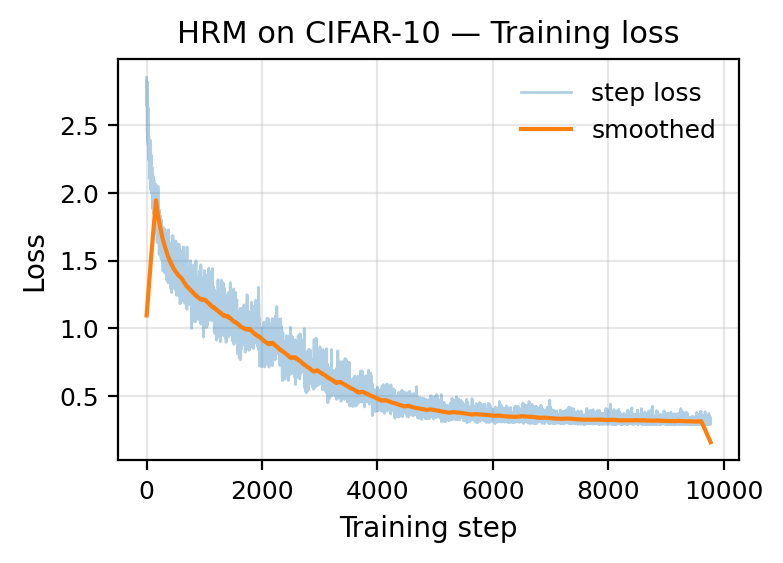

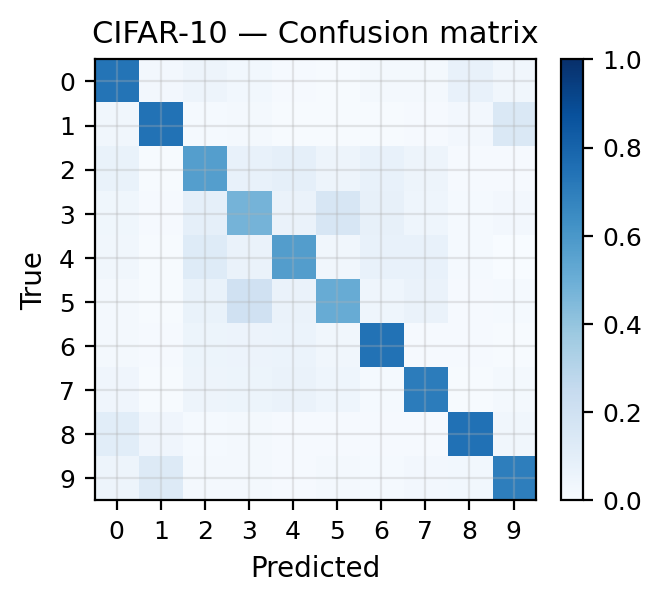

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7069967..2.1267862].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7828351..2.055835].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6742254..2.1158006].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9892052..2.1106803].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8780829..1.8368787].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5292716..2.1267862].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8836032

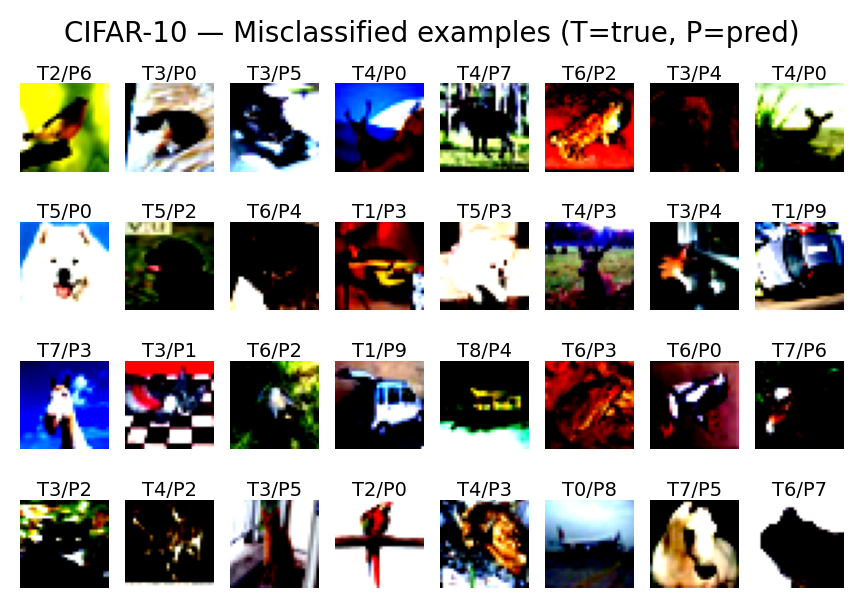

[cifar10_hrm_D192_H2_L3_seg2_seed1234] Params=3,552,576, Test acc=65.04%
Saved figures to: results/cifar10_hrm_D192_H2_L3_seg2_seed1234


In [ ]:

def smooth_c10(y, k=21):
    if k <= 1 or k > len(y): return y
    w = np.ones(k) / k
    return np.convolve(y, w, mode="same")


fig, ax = plt.subplots(figsize=(3.8, 2.7), constrained_layout=True)
ax.plot(step_loss_c10, lw=1.0, alpha=0.35, label="step loss")
ax.plot(smooth_c10(step_loss_c10, k=max(11, len(step_loss_c10)//30)), lw=1.5, label="smoothed")
ax.set_xlabel("Training step")
ax.set_ylabel("Loss")
ax.set_title("HRM on CIFAR-10 — Training loss", pad=6)
ax.legend(loc="best", frameon=False)
fig.savefig(RUN_DIR_C10 / "loss_curve.pdf", bbox_inches="tight")
fig.savefig(RUN_DIR_C10 / "loss_curve.png", bbox_inches="tight")
plt.show()


y_true_c10, y_pred_c10 = [], []
test_it = batch_iterator(x_test_c10, y_test_c10, cfg_c10.batch_size, shuffle=False, seed=0)
for xb, yb in test_it:
    bsz = xb.shape[0]
    z_pair = (tile_state(z0H_t_c10, bsz), tile_state(z0L_t_c10, bsz))
    logits = None
    for _ in range(cfg_c10.num_segments_eval):
        (z_pair, logits) = model_c10.apply(
            {"params": params_c10},
            xb, z_pair,
            cfg_c10.num_high_cycles, cfg_c10.num_low_steps_per_cycle,
            False, False
        )
        z_pair = (jax.lax.stop_gradient(z_pair[0]), jax.lax.stop_gradient(z_pair[1]))
    y_true_c10.append(np.asarray(yb))
    y_pred_c10.append(np.asarray(jnp.argmax(logits, axis=-1)))

y_true_c10 = np.concatenate(y_true_c10)
y_pred_c10 = np.concatenate(y_pred_c10)

from sklearn.metrics import confusion_matrix
cm_c10 = confusion_matrix(y_true_c10, y_pred_c10, labels=np.arange(cfg_c10.num_classes))
cm_norm_c10 = cm_c10 / cm_c10.sum(axis=1, keepdims=True)
np.save(RUN_DIR_C10 / "confusion_matrix.npy", cm_c10)

fig, ax = plt.subplots(figsize=(3.8, 2.9), constrained_layout=True)
im = ax.imshow(cm_norm_c10, interpolation="nearest", cmap="Blues", vmin=0.0, vmax=1.0)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_xticks(range(cfg_c10.num_classes))
ax.set_yticks(range(cfg_c10.num_classes))
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("CIFAR-10 — Confusion matrix", pad=6)
fig.savefig(RUN_DIR_C10 / "confusion_matrix.pdf", bbox_inches="tight")
fig.savefig(RUN_DIR_C10 / "confusion_matrix.png", bbox_inches="tight")
plt.show()


mis_idx = np.where(y_true_c10 != y_pred_c10)[0]
np.random.default_rng(cfg_c10.seed).shuffle(mis_idx)
mis_idx = mis_idx[:32]

if mis_idx.size > 0:
    cols = 8
    rows = int(np.ceil(len(mis_idx) / cols))
    fig, axes = plt.subplots(
        rows, cols,
        figsize=(4.2, 0.55 * rows + 0.8),
        constrained_layout=True
    )
    if rows == 1:
        axes = np.array([axes])
    for ax in axes.ravel(): ax.axis("off")

    for i, idx in enumerate(mis_idx):
        r, c = divmod(i, cols)
        ax = axes[r, c]
        ax.imshow(x_test_c10[idx])
        ax.axis("off")
        ax.set_title(f"T{int(y_true_c10[idx])}/P{int(y_pred_c10[idx])}", fontsize=7, pad=1.5)

    fig.suptitle("CIFAR-10 - Misclassified examples (T=true, P=pred)", fontsize=10)
    fig.savefig(RUN_DIR_C10 / "errors_grid.pdf", bbox_inches="tight", pad_inches=0.03)
    fig.savefig(RUN_DIR_C10 / "errors_grid.png", bbox_inches="tight", pad_inches=0.03)
    plt.show()

print(f"[{RUN_NAME_C10}] Params={count_params(params_c10):,}, Test acc={test_acc_c10*100:.2f}%")
print("Saved figures to:", RUN_DIR_C10)


In [ ]:

print(f"CIFAR-10 final test accuracy: {test_acc_c10:.4f}")
print(f"CIFAR-10 total parameters: {count_params(params_c10):,}")
for r in epoch_rows_c10:
    print(f"Epoch {r['epoch']:02d}  train_loss={r['train_loss']:.4f}  train_acc={r['train_acc']:.4f}")


CIFAR-10 final test accuracy: 0.6504
CIFAR-10 total parameters: 3,552,576
Epoch 01  train_loss=1.8737  train_acc=0.3421
Epoch 02  train_loss=1.3745  train_acc=0.5523
Epoch 03  train_loss=1.2117  train_acc=0.6237
Epoch 04  train_loss=1.0900  train_acc=0.6763
Epoch 05  train_loss=0.9900  train_acc=0.7185
Epoch 06  train_loss=0.8853  train_acc=0.7609
Epoch 07  train_loss=0.7818  train_acc=0.8055
Epoch 08  train_loss=0.6825  train_acc=0.8447
Epoch 09  train_loss=0.5990  train_acc=0.8785
Epoch 10  train_loss=0.5266  train_acc=0.9089
Epoch 11  train_loss=0.4657  train_acc=0.9324
Epoch 12  train_loss=0.4242  train_acc=0.9483
Epoch 13  train_loss=0.3981  train_acc=0.9589
Epoch 14  train_loss=0.3785  train_acc=0.9666
Epoch 15  train_loss=0.3640  train_acc=0.9719
Epoch 16  train_loss=0.3530  train_acc=0.9753
Epoch 17  train_loss=0.3482  train_acc=0.9769
Epoch 18  train_loss=0.3383  train_acc=0.9801
Epoch 19  train_loss=0.3317  train_acc=0.9833
Epoch 20  train_loss=0.3252  train_acc=0.9850
Epoch 

### CIFAR10 CNN baseline

In [ ]:

from dataclasses import dataclass
import jax, jax.numpy as jnp
import numpy as np
from tqdm import tqdm
import flax, flax.linen as nn
import optax
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd


try:
    x_train_c10
    y_train_c10
    x_test_c10
    y_test_c10
    c10_mean, c10_std
except NameError:
    (x_train_c10, y_train_c10), (x_test_c10, y_test_c10) = load_cifar10()
    (x_train_c10, (c10_mean, c10_std)) = standardize_per_channel(x_train_c10)
    (x_test_c10,  _) = standardize_per_channel(x_test_c10, mean=c10_mean, std=c10_std)

@dataclass
class CNNConfig:
    dataset_name: str = "cifar10"
    image_shape: tuple = (32, 32, 3)
    num_classes: int = 10
    # Model
    base_width: int = 64          # 
    dropout_rate: float = 0.0     #  0.0 for raw
    # Optimization
    learning_rate: float = 3e-4
    weight_decay: float = 5e-4
    batch_size: int = 128
    num_epochs: int = 25
    seed: int = 2025
    label_smoothing: float = 0.05
    # LR schedule
    warmup_epochs: int = 1
    floor_ratio: float = 0.20

cfg_cnn = CNNConfig()


mpl.rcParams.update({
    "figure.figsize": (3.8, 2.7),
    "figure.dpi": 200,
    "savefig.dpi": 300,
    "font.size": 10,
    "axes.titlesize": 11,
    "axes.labelsize": 10,
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "axes.grid": True,
    "grid.alpha": 0.3,
})
mpl.rcParams['figure.constrained_layout.use'] = True

RUN_NAME_C10_CNN = f"cifar10_cnn_W{cfg_cnn.base_width}_seed{cfg_cnn.seed}"
RUN_DIR_C10_CNN = Path("./results") / RUN_NAME_C10_CNN
RUN_DIR_C10_CNN.mkdir(parents=True, exist_ok=True)

steps_per_epoch_cnn = (len(x_train_c10) + cfg_cnn.batch_size - 1) // cfg_cnn.batch_size
keygen_cnn = split_key(cfg_cnn.seed)


In [ ]:

class SmallCNN(nn.Module):
    num_classes: int
    base_width: int = 64
    dropout_rate: float = 0.0

    @nn.compact
    def __call__(self, x: jnp.ndarray, training: bool) -> jnp.ndarray:
        # 1: 32x32 -> 16x16
        x = nn.Conv(self.base_width, (3, 3), padding="SAME", use_bias=False)(x)
        x = nn.BatchNorm(use_running_average=not training, momentum=0.9, epsilon=1e-5)(x)
        x = nn.relu(x)
        x = nn.Conv(self.base_width, (3, 3), padding="SAME", use_bias=False)(x)
        x = nn.BatchNorm(use_running_average=not training, momentum=0.9, epsilon=1e-5)(x)
        x = nn.relu(x)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2), padding="VALID")  # 16x16

        # Block 2: 16x16 -> 8x8
        x = nn.Conv(self.base_width * 2, (3, 3), padding="SAME", use_bias=False)(x)
        x = nn.BatchNorm(use_running_average=not training, momentum=0.9, epsilon=1e-5)(x)
        x = nn.relu(x)
        x = nn.Conv(self.base_width * 2, (3, 3), padding="SAME", use_bias=False)(x)
        x = nn.BatchNorm(use_running_average=not training, momentum=0.9, epsilon=1e-5)(x)
        x = nn.relu(x)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2), padding="VALID")  # 8x8

        # Classifier head
        if self.dropout_rate > 0.0:
            x = nn.Dropout(self.dropout_rate)(x, deterministic=not training)
        x = jnp.mean(x, axis=(1, 2))  # Global Average Pooling
        logits = nn.Dense(self.num_classes, use_bias=False)(x)
        return logits


In [ ]:
def make_optimizer_with_warmup_floor_for_cnn(cfg: CNNConfig, steps_per_epoch: int, mask=None):
    total_steps = steps_per_epoch * cfg.num_epochs
    warmup_steps = steps_per_epoch * cfg.warmup_epochs

    warmup = optax.linear_schedule(init_value=0.0,
                                   end_value=cfg.learning_rate,
                                   transition_steps=warmup_steps)
    cosine = optax.cosine_decay_schedule(init_value=cfg.learning_rate,
                                         decay_steps=total_steps,
                                         alpha=cfg.floor_ratio)
    lr_schedule = optax.join_schedules([warmup, cosine], boundaries=[warmup_steps])

    tx = optax.chain(
        optax.clip_by_global_norm(1.0),
        optax.adamw(learning_rate=lr_schedule, weight_decay=cfg.weight_decay, mask=mask)
    )
    return tx


USE_DECAY_MASK = False

def make_decay_mask_for_cnn(params):
    from flax.traverse_util import flatten_dict, unflatten_dict
    flat = flatten_dict(params, sep='/')
    mask_flat = {}
    for k, v in flat.items():
        name = k
        # 
        if name.endswith('/bias') or name.endswith('/scale') or 'BatchNorm' in name or v.ndim < 2:
            mask_flat[k] = False
        else:
            mask_flat[k] = True
    return unflatten_dict(mask_flat, sep='/')


In [ ]:

model_cnn = SmallCNN(num_classes=cfg_cnn.num_classes,
                     base_width=cfg_cnn.base_width,
                     dropout_rate=cfg_cnn.dropout_rate)

dummy_c10 = jnp.zeros((1,) + cfg_cnn.image_shape, dtype=jnp.float32)
variables_cnn = model_cnn.init(next(keygen_cnn), dummy_c10, training=True)
params_cnn = variables_cnn["params"]
batch_stats_cnn = variables_cnn.get("batch_stats", {})

# 
decay_mask = make_decay_mask_for_cnn(params_cnn) if USE_DECAY_MASK else None
optimizer_cnn = make_optimizer_with_warmup_floor_for_cnn(cfg_cnn, steps_per_epoch_cnn, mask=decay_mask)
opt_state_cnn = optimizer_cnn.init(params_cnn)

print("CNN parameter count:", count_params(params_cnn))


CNN parameter count: 261824


In [ ]:

def label_smoothed_ce(logits: jnp.ndarray, labels: jnp.ndarray, num_classes: int, epsilon: float) -> jnp.ndarray:
    one_hot = jax.nn.one_hot(labels, num_classes=num_classes)
    smoothed = (1.0 - epsilon) * one_hot + (epsilon / num_classes)
    log_probs = jax.nn.log_softmax(logits, axis=-1)
    return -(smoothed * log_probs).sum(axis=-1).mean()

def accuracy_from_logits(logits: jnp.ndarray, labels: jnp.ndarray) -> jnp.ndarray:
    return (jnp.argmax(logits, axis=-1) == labels).mean()

@jax.jit
def train_step_cnn(params, batch_stats, opt_state, images, labels):
    def loss_fn(p, bstats):
        variables = {"params": p, "batch_stats": bstats}
        logits, new_state = model_cnn.apply(variables, images, training=True, mutable=["batch_stats"])
        loss = label_smoothed_ce(logits, labels, cfg_cnn.num_classes, cfg_cnn.label_smoothing)
        acc  = accuracy_from_logits(logits, labels)
        return loss, (new_state["batch_stats"], acc)

    (loss, (new_batch_stats, acc)), grads = jax.value_and_grad(loss_fn, has_aux=True)(params, batch_stats)
    updates, opt_state = optimizer_cnn.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, new_batch_stats, opt_state, loss, acc

@jax.jit
def eval_logits_cnn(params, batch_stats, images):
    variables = {"params": params, "batch_stats": batch_stats}
    logits = model_cnn.apply(variables, images, training=False, mutable=False)
    return logits

def evaluate_cnn(params, batch_stats, x, y, batch_size: int) -> float:
    it = batch_iterator(x, y, batch_size, shuffle=False, seed=0)
    total_correct = 0
    total = 0
    for xb, yb in it:
        logits = eval_logits_cnn(params, batch_stats, xb)
        preds = np.asarray(jnp.argmax(logits, axis=-1))
        y_true = np.asarray(yb)
        total_correct += int((preds == y_true).sum())
        total += int(preds.size)
    return total_correct / total


In [ ]:
step_loss_c10_cnn = []
step_acc_c10_cnn  = []
epoch_train_acc_c10_cnn = []
epoch_test_acc_c10_cnn  = []

for epoch in range(1, cfg_cnn.num_epochs + 1):
    it = batch_iterator(x_train_c10, y_train_c10, cfg_cnn.batch_size, shuffle=True, seed=cfg_cnn.seed + epoch)
    running_loss = 0.0
    running_acc  = 0.0
    n_batches = 0

    for xb, yb in tqdm(it, total=steps_per_epoch_cnn, desc=f"[CNN] Epoch {epoch}"):
        params_cnn, batch_stats_cnn, opt_state_cnn, loss_b, acc_b = train_step_cnn(
            params_cnn, batch_stats_cnn, opt_state_cnn, xb, yb
        )
        loss_b, acc_b = float(loss_b), float(acc_b)
        step_loss_c10_cnn.append(loss_b)
        step_acc_c10_cnn.append(acc_b)
        running_loss += loss_b
        running_acc  += acc_b
        n_batches += 1

    
    train_acc_epoch = running_acc / n_batches
    epoch_train_acc_c10_cnn.append(train_acc_epoch)

    test_acc_epoch = evaluate_cnn(params_cnn, batch_stats_cnn, x_test_c10, y_test_c10, cfg_cnn.batch_size)
    epoch_test_acc_c10_cnn.append(float(test_acc_epoch))

    print(f"[CNN] Epoch {epoch:02d} | train loss {running_loss/n_batches:.4f} | "
          f"train acc {train_acc_epoch:.4f} | test acc {test_acc_epoch:.4f}")

final_test_acc_c10_cnn = epoch_test_acc_c10_cnn[-1]
print(f"[CNN] Final test accuracy: {final_test_acc_c10_cnn:.4f}")
print(f"[CNN] Total parameters: {count_params(params_cnn):,}")


[CNN] Epoch 1: 100%|██████████| 391/391 [00:21<00:00, 18.06it/s]


[CNN] Epoch 01 | train loss 1.7805 | train acc 0.3873 | test acc 0.4968


[CNN] Epoch 2: 100%|██████████| 391/391 [00:12<00:00, 32.48it/s]


[CNN] Epoch 02 | train loss 1.3801 | train acc 0.5649 | test acc 0.5731


[CNN] Epoch 3: 100%|██████████| 391/391 [00:11<00:00, 33.05it/s]


[CNN] Epoch 03 | train loss 1.2494 | train acc 0.6184 | test acc 0.5532


[CNN] Epoch 4: 100%|██████████| 391/391 [00:12<00:00, 32.10it/s]


[CNN] Epoch 04 | train loss 1.1663 | train acc 0.6587 | test acc 0.5506


[CNN] Epoch 5: 100%|██████████| 391/391 [00:12<00:00, 31.11it/s]


[CNN] Epoch 05 | train loss 1.1079 | train acc 0.6808 | test acc 0.6619


[CNN] Epoch 6: 100%|██████████| 391/391 [00:12<00:00, 31.63it/s]


[CNN] Epoch 06 | train loss 1.0573 | train acc 0.7035 | test acc 0.6294


[CNN] Epoch 7: 100%|██████████| 391/391 [00:12<00:00, 31.34it/s]


[CNN] Epoch 07 | train loss 1.0158 | train acc 0.7215 | test acc 0.6631


[CNN] Epoch 8: 100%|██████████| 391/391 [00:12<00:00, 31.16it/s]


[CNN] Epoch 08 | train loss 0.9776 | train acc 0.7388 | test acc 0.6687


[CNN] Epoch 9: 100%|██████████| 391/391 [00:12<00:00, 31.29it/s]


[CNN] Epoch 09 | train loss 0.9485 | train acc 0.7504 | test acc 0.6201


[CNN] Epoch 10: 100%|██████████| 391/391 [00:12<00:00, 31.36it/s]


[CNN] Epoch 10 | train loss 0.9183 | train acc 0.7631 | test acc 0.7137


[CNN] Epoch 11: 100%|██████████| 391/391 [00:12<00:00, 31.32it/s]


[CNN] Epoch 11 | train loss 0.8938 | train acc 0.7749 | test acc 0.6816


[CNN] Epoch 12: 100%|██████████| 391/391 [00:12<00:00, 31.32it/s]


[CNN] Epoch 12 | train loss 0.8692 | train acc 0.7868 | test acc 0.7151


[CNN] Epoch 13: 100%|██████████| 391/391 [00:12<00:00, 31.11it/s]


[CNN] Epoch 13 | train loss 0.8497 | train acc 0.7941 | test acc 0.7119


[CNN] Epoch 14: 100%|██████████| 391/391 [00:12<00:00, 31.08it/s]


[CNN] Epoch 14 | train loss 0.8318 | train acc 0.8016 | test acc 0.6769


[CNN] Epoch 15: 100%|██████████| 391/391 [00:12<00:00, 31.71it/s]


[CNN] Epoch 15 | train loss 0.8150 | train acc 0.8126 | test acc 0.7434


[CNN] Epoch 16: 100%|██████████| 391/391 [00:12<00:00, 31.21it/s]


[CNN] Epoch 16 | train loss 0.8000 | train acc 0.8180 | test acc 0.7411


[CNN] Epoch 17: 100%|██████████| 391/391 [00:12<00:00, 31.49it/s]


[CNN] Epoch 17 | train loss 0.7859 | train acc 0.8233 | test acc 0.7451


[CNN] Epoch 18: 100%|██████████| 391/391 [00:12<00:00, 31.46it/s]


[CNN] Epoch 18 | train loss 0.7699 | train acc 0.8311 | test acc 0.7452


[CNN] Epoch 19: 100%|██████████| 391/391 [00:12<00:00, 31.20it/s]


[CNN] Epoch 19 | train loss 0.7601 | train acc 0.8362 | test acc 0.7553


[CNN] Epoch 20: 100%|██████████| 391/391 [00:12<00:00, 32.18it/s]


[CNN] Epoch 20 | train loss 0.7506 | train acc 0.8399 | test acc 0.7604


[CNN] Epoch 21: 100%|██████████| 391/391 [00:12<00:00, 31.88it/s]


[CNN] Epoch 21 | train loss 0.7400 | train acc 0.8434 | test acc 0.7701


[CNN] Epoch 22: 100%|██████████| 391/391 [00:12<00:00, 31.13it/s]


[CNN] Epoch 22 | train loss 0.7325 | train acc 0.8470 | test acc 0.7726


[CNN] Epoch 23: 100%|██████████| 391/391 [00:12<00:00, 31.31it/s]


[CNN] Epoch 23 | train loss 0.7252 | train acc 0.8518 | test acc 0.7644


[CNN] Epoch 24: 100%|██████████| 391/391 [00:12<00:00, 31.33it/s]


[CNN] Epoch 24 | train loss 0.7195 | train acc 0.8538 | test acc 0.7744


[CNN] Epoch 25: 100%|██████████| 391/391 [00:12<00:00, 31.41it/s]


[CNN] Epoch 25 | train loss 0.7125 | train acc 0.8586 | test acc 0.7722
[CNN] Final test accuracy: 0.7722
[CNN] Total parameters: 261,824


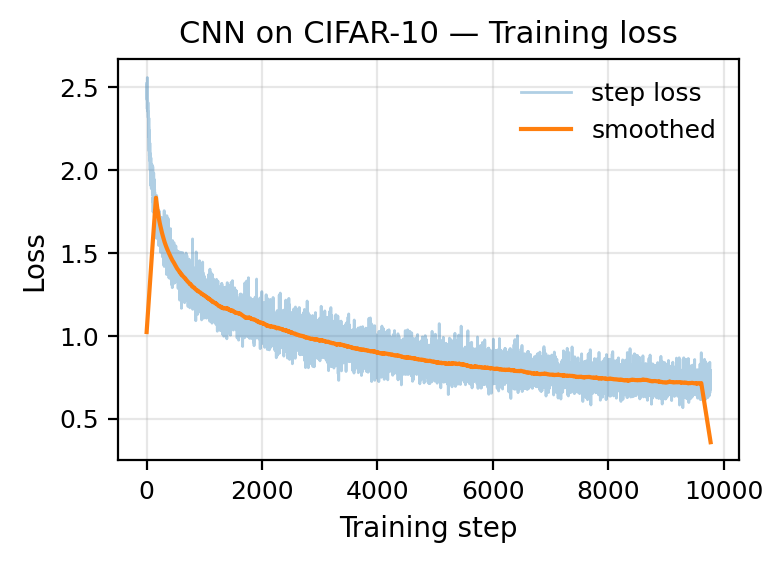

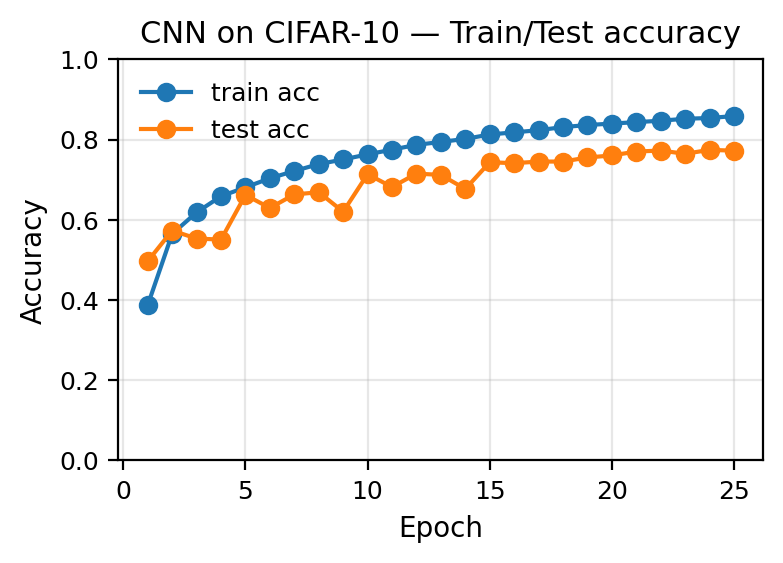

In [ ]:

def smooth_trace(y, k=21):
    if k <= 1 or k > len(y): 
        return y
    w = np.ones(k) / k
    return np.convolve(np.asarray(y), w, mode="same")


fig, ax = plt.subplots(figsize=(3.8, 2.7), constrained_layout=True)
ax.plot(step_loss_c10_cnn, lw=1.0, alpha=0.35, label="step loss")
ax.plot(smooth_trace(step_loss_c10_cnn, k=max(11, len(step_loss_c10_cnn)//30)), lw=1.5, label="smoothed")
ax.set_xlabel("Training step")
ax.set_ylabel("Loss")
ax.set_title("CNN on CIFAR-10 — Training loss", pad=6)
ax.legend(loc="best", frameon=False)
fig.savefig(RUN_DIR_C10_CNN / "loss_curve.pdf", bbox_inches="tight")
fig.savefig(RUN_DIR_C10_CNN / "loss_curve.png", bbox_inches="tight")
plt.show()


epochs = np.arange(1, cfg_cnn.num_epochs + 1)
fig, ax = plt.subplots(figsize=(3.8, 2.7), constrained_layout=True)
ax.plot(epochs, epoch_train_acc_c10_cnn, marker='o', lw=1.5, label="train acc")
ax.plot(epochs, epoch_test_acc_c10_cnn, marker='o', lw=1.5, label="test acc")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.set_ylim(0.0, 1.0)
ax.set_title("CNN on CIFAR-10 — Train/Test accuracy", pad=6)
ax.legend(loc="best", frameon=False)
fig.savefig(RUN_DIR_C10_CNN / "accuracy_curves.pdf", bbox_inches="tight")
fig.savefig(RUN_DIR_C10_CNN / "accuracy_curves.png", bbox_inches="tight")
plt.show()


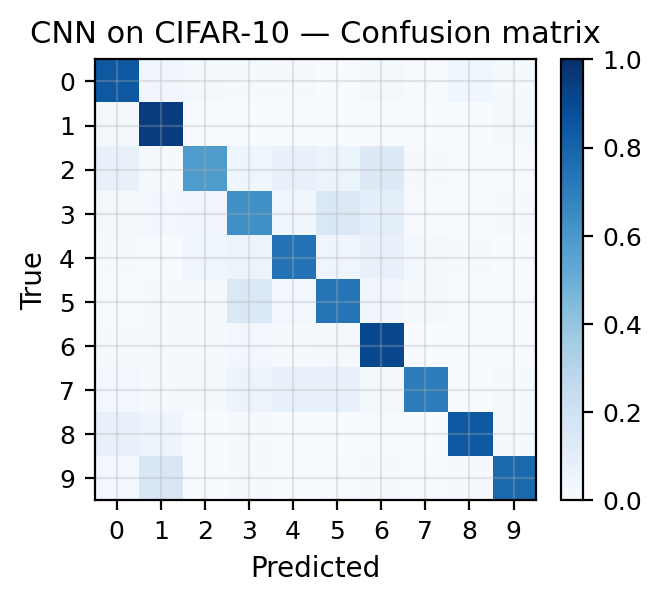

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5288411..0.57169044].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8939575..1.1926394].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8674972..2.058824].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7708613..1.3062671].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8836032..2.1267862].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7225434..2.0784683].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.989205

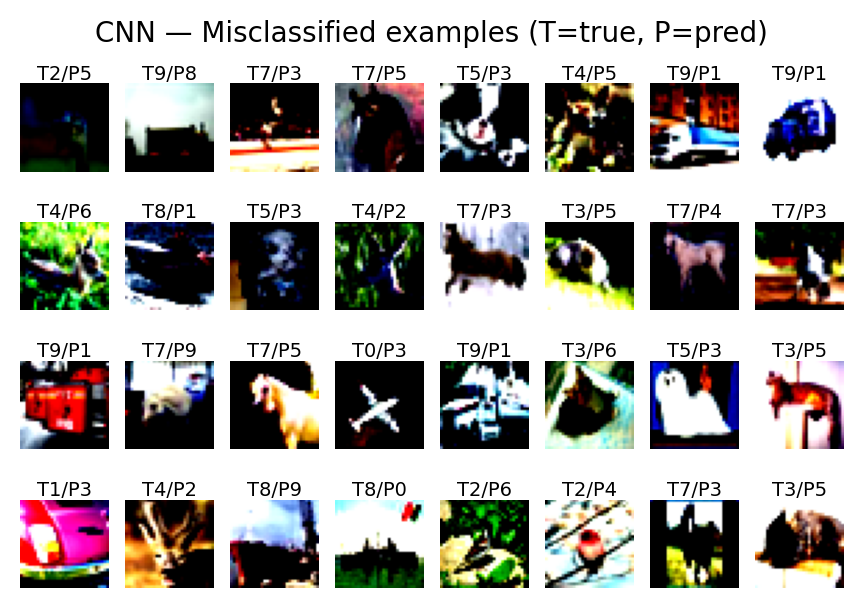

[cifar10_cnn_W64_seed2025] Params=261,824, Final Test acc=77.22%
Saved figures to: results/cifar10_cnn_W64_seed2025


In [ ]:

y_true_c10_cnn, y_pred_c10_cnn = [], []
it_test = batch_iterator(x_test_c10, y_test_c10, cfg_cnn.batch_size, shuffle=False, seed=0)
for xb, yb in it_test:
    logits = eval_logits_cnn(params_cnn, batch_stats_cnn, xb)
    y_true_c10_cnn.append(np.asarray(yb))
    y_pred_c10_cnn.append(np.asarray(jnp.argmax(logits, axis=-1)))

y_true_c10_cnn = np.concatenate(y_true_c10_cnn)
y_pred_c10_cnn = np.concatenate(y_pred_c10_cnn)

cm_c10_cnn = confusion_matrix(y_true_c10_cnn, y_pred_c10_cnn, labels=np.arange(cfg_cnn.num_classes))
cm_norm_c10_cnn = cm_c10_cnn / cm_c10_cnn.sum(axis=1, keepdims=True)
np.save(RUN_DIR_C10_CNN / "confusion_matrix.npy", cm_c10_cnn)

fig, ax = plt.subplots(figsize=(3.8, 2.9), constrained_layout=True)
im = ax.imshow(cm_norm_c10_cnn, interpolation="nearest", cmap="Blues", vmin=0.0, vmax=1.0)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_xticks(range(cfg_cnn.num_classes))
ax.set_yticks(range(cfg_cnn.num_classes))
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("CNN on CIFAR-10 - Confusion matrix", pad=6)
fig.savefig(RUN_DIR_C10_CNN / "confusion_matrix.pdf", bbox_inches="tight")
fig.savefig(RUN_DIR_C10_CNN / "confusion_matrix.png", bbox_inches="tight")
plt.show()

#
mis_idx = np.where(y_true_c10_cnn != y_pred_c10_cnn)[0]
np.random.default_rng(cfg_cnn.seed).shuffle(mis_idx)
mis_idx = mis_idx[:32]

if mis_idx.size > 0:
    cols = 8
    rows = int(np.ceil(len(mis_idx) / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(4.2, 0.55 * rows + 0.8), constrained_layout=True)
    if rows == 1:
        axes = np.array([axes])
    for ax in axes.ravel(): 
        ax.axis("off")
    for i, idx in enumerate(mis_idx):
        r, c = divmod(i, cols)
        ax = axes[r, c]
        ax.imshow(x_test_c10[idx])
        ax.axis("off")
        ax.set_title(f"T{int(y_true_c10_cnn[idx])}/P{int(y_pred_c10_cnn[idx])}", fontsize=7, pad=1.5)

    fig.suptitle("CNN - Misclassified examples (T=true, P=pred)", fontsize=10)
    fig.savefig(RUN_DIR_C10_CNN / "errors_grid.pdf", bbox_inches="tight", pad_inches=0.03)
    fig.savefig(RUN_DIR_C10_CNN / "errors_grid.png", bbox_inches="tight")
    plt.show()

print(f"[{RUN_NAME_C10_CNN}] Params={count_params(params_cnn):,}, Final Test acc={final_test_acc_c10_cnn*100:.2f}%")
print("Saved figures to:", RUN_DIR_C10_CNN)


In [ ]:

np.savez(
    RUN_DIR_C10_CNN / "metrics.npz",
    step_loss=np.array(step_loss_c10_cnn, np.float32),
    step_acc=np.array(step_acc_c10_cnn, np.float32),
    epoch=np.arange(1, cfg_cnn.num_epochs + 1),
    epoch_train_acc=np.array(epoch_train_acc_c10_cnn, np.float32),
    epoch_test_acc=np.array(epoch_test_acc_c10_cnn, np.float32),
    n_params=np.int64(count_params(params_cnn)),
)

pd.DataFrame({
    "epoch": np.arange(1, cfg_cnn.num_epochs + 1),
    "train_acc": epoch_train_acc_c10_cnn,
    "test_acc": epoch_test_acc_c10_cnn
}).to_csv(RUN_DIR_C10_CNN / "epoch_metrics.csv", index=False)


# CIFAR-100 HRM

In [ ]:

import os, tarfile, pickle, urllib.request, pathlib, time
import numpy as np

C100_DATA_DIR = pathlib.Path("./data").resolve()
C100_DATA_DIR.mkdir(parents=True, exist_ok=True)
_C100_TGZ = C100_DATA_DIR / "cifar-100-python.tar.gz"
_C100_EXTRACT_DIR = C100_DATA_DIR / "cifar-100-python"
_C100_URLS = [
    "https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz",
]

def _download_with_retries_c100(url: str, dest: pathlib.Path, retries: int = 3, delay: float = 1.0):
    last_err = None
    for k in range(1, retries + 1):
        try:
            urllib.request.urlretrieve(url, dest)
            return
        except Exception as e:
            last_err = e
            time.sleep(delay * k)
    raise RuntimeError(f"Failed to download CIFAR-100 from {url}: {last_err}")

def _ensure_cifar100_tgz():
    if not _C100_TGZ.exists() or _C100_TGZ.stat().st_size < 16_000_000:
        for url in _C100_URLS:
            try:
                print(f"Downloading CIFAR-100 from {url} ...")
                _download_with_retries_c100(url, _C100_TGZ, retries=3, delay=1.0)
                break
            except Exception as e:
                print("Download error:", e)
        else:
            raise RuntimeError("Could not download CIFAR-100 from any source.")

def _ensure_cifar100_extracted():
    if not _C100_EXTRACT_DIR.exists():
        print("Extracting", _C100_TGZ)
        with tarfile.open(_C100_TGZ, "r:gz") as tar:
            tar.extractall(C100_DATA_DIR)

def _load_cifar100_file(path: pathlib.Path):
    with open(path, "rb") as f:
        d = pickle.load(f, encoding="latin1")  
    x = d["data"].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # NCHW->NHWC
    y = np.array(d["fine_labels"], dtype=np.int32)
    return x.astype(np.float32) / 255.0, y

def load_cifar100():
    """Return (x_train, y_train), (x_test, y_test), all float32 in [0,1]."""
    _ensure_cifar100_tgz()
    _ensure_cifar100_extracted()
    x_train, y_train = _load_cifar100_file(_C100_EXTRACT_DIR / "train")
    x_test,  y_test  = _load_cifar100_file(_C100_EXTRACT_DIR / "test")
    return (x_train, y_train), (x_test, y_test)


In [ ]:

cfg_c100 = HRMConfig(
    dataset_name="cifar100",
    image_shape=(32, 32, 3),
    num_classes=100,
    patch_size=4,             # 32x32 -> 8x8 grid + [CLS]
    d_model=192,            
    num_heads=6,              # 
    mlp_mult=4,
    num_layers_L=3,
    num_layers_H=3,
    num_high_cycles=2,
    num_low_steps_per_cycle=3,
    num_segments_train=2,
    num_segments_eval=3,
    learning_rate=3e-4,
    weight_decay=5e-4,
    batch_size=128,
    num_epochs=25,            #
    seed=2468,
)
print(cfg_c100)


HRMConfig(dataset_name='cifar100', image_shape=(32, 32, 3), num_classes=100, patch_size=4, d_model=192, num_heads=6, mlp_mult=4, num_layers_L=3, num_layers_H=3, num_high_cycles=2, num_low_steps_per_cycle=3, num_segments_train=2, num_segments_eval=3, use_act_train=False, act_lambda=0.1, act_epsilon=0.2, act_max_segments=4, learning_rate=0.0003, weight_decay=0.0005, batch_size=128, num_epochs=25, seed=2468)


In [ ]:

(x_train_c100, y_train_c100), (x_test_c100, y_test_c100) = load_cifar100()
(x_train_c100, (c100_mean, c100_std)) = standardize_per_channel(x_train_c100)
(x_test_c100,  _) = standardize_per_channel(x_test_c100, mean=c100_mean, std=c100_std)

print("CIFAR-100 shapes:", x_train_c100.shape, y_train_c100.shape, "|", x_test_c100.shape, y_test_c100.shape)


Extracting /home/meow/Documents/repos/ImagesHRM/simple-images/data/cifar-100-python.tar.gz
CIFAR-100 shapes: (50000, 32, 32, 3) (50000,) | (10000, 32, 32, 3) (10000,)


In [ ]:

import jax, jax.numpy as jnp
import optax
from tqdm import tqdm


keygen_c100 = split_key(cfg_c100.seed)
dummy_c100 = jnp.zeros((1,) + cfg_c100.image_shape, dtype=jnp.float32)

model_c100 = HRMCore(
    cfg_c100.d_model, cfg_c100.num_heads, cfg_c100.mlp_mult,
    cfg_c100.num_layers_L, cfg_c100.num_layers_H,
    cfg_c100.num_classes, cfg_c100.patch_size
)

variables_c100 = model_c100.init(
    next(keygen_c100),
    dummy_c100,
    (
        truncated_normal(next(keygen_c100), (1, compute_seq_len(cfg_c100.image_shape, cfg_c100.patch_size), cfg_c100.d_model)),
        truncated_normal(next(keygen_c100), (1, compute_seq_len(cfg_c100.image_shape, cfg_c100.patch_size), cfg_c100.d_model)),
    ),
    cfg_c100.num_high_cycles, cfg_c100.num_low_steps_per_cycle,
    True, False
)
params_c100 = variables_c100["params"]
print("CIFAR-100 parameter count:", count_params(params_c100))

steps_per_epoch_c100 = (len(x_train_c100) + cfg_c100.batch_size - 1) // cfg_c100.batch_size
optimizer_c100 = make_optimizer_with_warmup_floor(cfg_c100, steps_per_epoch_c100,
                                                  warmup_epochs=1, floor_ratio=0.20)
opt_state_c100 = optimizer_c100.init(params_c100)

# Fied initial states (kept fixed; fresh tiled per batch)
z0H_t_c100, z0L_t_c100 = make_initial_states_template(cfg_c100, next(keygen_c100))


CIFAR-100 parameter count: 3569856


In [ ]:

from functools import partial as _partial

@_partial(jax.jit, static_argnums=(4, 5, 6, 7))
def train_step_and_metrics_c100(
    params,
    opt_state,
    images,
    labels,
    num_segments_train: int,
    num_segments_eval: int,
    num_high_cycles: int,
    num_low_steps_per_cycle: int,
):
    """
    Fused TRAIN + METRICS for one batch, exactly as in CIFAR-10:
      - Train: run `num_segments_train` segments, updating params each segment.
      - Eval:  fresh init states + image copy; return scalar (loss, acc).
    """
    bsz = images.shape[0]
    num_classes = cfg_c100.num_classes
    epsilon = 0.05  # label smoothing

    #  TRAIN 
    z_pair_train = (tile_state(z0H_t_c100, bsz), tile_state(z0L_t_c100, bsz))

    def train_body(i, carry):
        params_i, opt_state_i, z_pair_i = carry

        def loss_fn(p, z_in):
            (z_new, logits) = model_c100.apply(
                {"params": p},
                images,
                z_in,
                num_high_cycles,
                num_low_steps_per_cycle,
                True,   # training=True
                False,  # return_q=False
            )
            one_hot = jax.nn.one_hot(labels, num_classes)
            smoothed = (1.0 - epsilon) * one_hot + epsilon / num_classes
            log_probs = jax.nn.log_softmax(logits, axis=-1)
            loss = -(smoothed * log_probs).sum(axis=-1).mean()

            zH, zL = z_new
            z_next = (jax.lax.stop_gradient(zH), jax.lax.stop_gradient(zL))
            return loss, z_next

        (loss_i, z_next), grads = jax.value_and_grad(loss_fn, has_aux=True)(params_i, z_pair_i)
        updates, opt_state_i = optimizer_c100.update(grads, opt_state_i, params_i)
        params_i = optax.apply_updates(params_i, updates)
        return (params_i, opt_state_i, z_next)

    params, opt_state, _ = jax.lax.fori_loop(
        0, num_segments_train, train_body, (params, opt_state, z_pair_train)
    )

    
    z_pair_eval = (tile_state(z0H_t_c100, bsz), tile_state(z0L_t_c100, bsz))
    images_eval = jnp.array(images, copy=True)

    logits_init = jnp.zeros((bsz, num_classes), dtype=jnp.float32)

    def eval_body(i, carry):
        z_pair_i, _ = carry
        (z_pair_i, logits_i) = model_c100.apply(
            {"params": params},
            images_eval,
            z_pair_i,
            num_high_cycles,
            num_low_steps_per_cycle,
            False,  # training=False
            False
        )
        z_pair_i = (jax.lax.stop_gradient(z_pair_i[0]), jax.lax.stop_gradient(z_pair_i[1]))
        return (z_pair_i, logits_i)

    _, logits = jax.lax.fori_loop(0, num_segments_eval, eval_body, (z_pair_eval, logits_init))

    one_hot_eval = jax.nn.one_hot(labels, num_classes)
    smoothed_eval = (1.0 - epsilon) * one_hot_eval + epsilon / num_classes
    log_probs_eval = jax.nn.log_softmax(logits, axis=-1)
    loss = -(smoothed_eval * log_probs_eval).sum(axis=-1).mean()

    acc  = (jnp.argmax(logits, axis=-1) == labels).mean()
    return params, opt_state, loss, acc


In [ ]:

from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

mpl.rcParams.update({
    "figure.figsize": (3.8, 2.7),
    "figure.dpi": 200,
    "savefig.dpi": 300,
    "font.size": 10,
    "axes.titlesize": 11,
    "axes.labelsize": 10,
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "axes.grid": True,
    "grid.alpha": 0.3,
})
mpl.rcParams['figure.constrained_layout.use'] = True

RUN_NAME_C100 = f"cifar100_hrm_D{cfg_c100.d_model}_H{cfg_c100.num_high_cycles}_L{cfg_c100.num_low_steps_per_cycle}_seg{cfg_c100.num_segments_train}_seed{cfg_c100.seed}"
RUN_DIR_C100 = Path("./results") / RUN_NAME_C100
RUN_DIR_C100.mkdir(parents=True, exist_ok=True)

step_loss_c100, step_acc_c100 = [], []
epoch_rows_c100 = []

for epoch in range(1, cfg_c100.num_epochs + 1):
    it = batch_iterator(x_train_c100, y_train_c100, cfg_c100.batch_size, shuffle=True, seed=cfg_c100.seed + epoch)
    run_loss = 0.0
    run_acc  = 0.0
    nb = 0
    for xb, yb in tqdm(it, total=steps_per_epoch_c100, desc=f"[CIFAR-100] Epoch {epoch}"):
        params_c100, opt_state_c100, l_dev, a_dev = train_step_and_metrics_c100(
            params_c100, opt_state_c100,
            xb, yb,
            cfg_c100.num_segments_train,
            cfg_c100.num_segments_eval,
            cfg_c100.num_high_cycles,
            cfg_c100.num_low_steps_per_cycle,
        )
        l_host, a_host = jax.device_get((l_dev, a_dev))
        l_host = float(l_host); a_host = float(a_host)

        step_loss_c100.append(l_host)
        step_acc_c100.append(a_host)
        run_loss += l_host; run_acc += a_host; nb += 1

    epoch_rows_c100.append({"epoch": epoch, "train_loss": run_loss/nb, "train_acc": run_acc/nb})
    print(f"[CIFAR-100] Epoch {epoch:02d} | train loss {run_loss/nb:.4f} | train acc {run_acc/nb:.4f}")


[CIFAR-100] Epoch 1: 100%|██████████| 391/391 [06:13<00:00,  1.05it/s]


[CIFAR-100] Epoch 01 | train loss 4.1566 | train acc 0.0775


[CIFAR-100] Epoch 2: 100%|██████████| 391/391 [05:52<00:00,  1.11it/s]


[CIFAR-100] Epoch 02 | train loss 3.6121 | train acc 0.1608


[CIFAR-100] Epoch 3: 100%|██████████| 391/391 [05:52<00:00,  1.11it/s]


[CIFAR-100] Epoch 03 | train loss 3.3055 | train acc 0.2250


[CIFAR-100] Epoch 4: 100%|██████████| 391/391 [05:52<00:00,  1.11it/s]


[CIFAR-100] Epoch 04 | train loss 3.0275 | train acc 0.2874


[CIFAR-100] Epoch 5: 100%|██████████| 391/391 [05:52<00:00,  1.11it/s]


[CIFAR-100] Epoch 05 | train loss 2.8019 | train acc 0.3411


[CIFAR-100] Epoch 6: 100%|██████████| 391/391 [05:52<00:00,  1.11it/s]


[CIFAR-100] Epoch 06 | train loss 2.5868 | train acc 0.3912


[CIFAR-100] Epoch 7: 100%|██████████| 391/391 [05:52<00:00,  1.11it/s]


[CIFAR-100] Epoch 07 | train loss 2.3675 | train acc 0.4454


[CIFAR-100] Epoch 8: 100%|██████████| 391/391 [05:52<00:00,  1.11it/s]


[CIFAR-100] Epoch 08 | train loss 2.1545 | train acc 0.5003


[CIFAR-100] Epoch 9: 100%|██████████| 391/391 [05:52<00:00,  1.11it/s]


[CIFAR-100] Epoch 09 | train loss 1.9344 | train acc 0.5598


[CIFAR-100] Epoch 10: 100%|██████████| 391/391 [05:52<00:00,  1.11it/s]


[CIFAR-100] Epoch 10 | train loss 1.7348 | train acc 0.6189


[CIFAR-100] Epoch 11: 100%|██████████| 391/391 [05:52<00:00,  1.11it/s]


[CIFAR-100] Epoch 11 | train loss 1.5607 | train acc 0.6692


[CIFAR-100] Epoch 12: 100%|██████████| 391/391 [05:52<00:00,  1.11it/s]


[CIFAR-100] Epoch 12 | train loss 1.4249 | train acc 0.7141


[CIFAR-100] Epoch 13: 100%|██████████| 391/391 [05:52<00:00,  1.11it/s]


[CIFAR-100] Epoch 13 | train loss 1.3195 | train acc 0.7443


[CIFAR-100] Epoch 14: 100%|██████████| 391/391 [05:52<00:00,  1.11it/s]


[CIFAR-100] Epoch 14 | train loss 1.2399 | train acc 0.7710


[CIFAR-100] Epoch 15: 100%|██████████| 391/391 [05:52<00:00,  1.11it/s]


[CIFAR-100] Epoch 15 | train loss 1.1840 | train acc 0.7875


[CIFAR-100] Epoch 16: 100%|██████████| 391/391 [05:52<00:00,  1.11it/s]


[CIFAR-100] Epoch 16 | train loss 1.1350 | train acc 0.8035


[CIFAR-100] Epoch 17: 100%|██████████| 391/391 [05:52<00:00,  1.11it/s]


[CIFAR-100] Epoch 17 | train loss 1.0823 | train acc 0.8200


[CIFAR-100] Epoch 18: 100%|██████████| 391/391 [05:52<00:00,  1.11it/s]


[CIFAR-100] Epoch 18 | train loss 1.0400 | train acc 0.8350


[CIFAR-100] Epoch 19: 100%|██████████| 391/391 [05:52<00:00,  1.11it/s]


[CIFAR-100] Epoch 19 | train loss 0.9941 | train acc 0.8512


[CIFAR-100] Epoch 20: 100%|██████████| 391/391 [05:52<00:00,  1.11it/s]


[CIFAR-100] Epoch 20 | train loss 0.9570 | train acc 0.8629


[CIFAR-100] Epoch 21: 100%|██████████| 391/391 [05:52<00:00,  1.11it/s]


[CIFAR-100] Epoch 21 | train loss 0.9277 | train acc 0.8732


[CIFAR-100] Epoch 22: 100%|██████████| 391/391 [05:52<00:00,  1.11it/s]


[CIFAR-100] Epoch 22 | train loss 0.8939 | train acc 0.8859


[CIFAR-100] Epoch 23: 100%|██████████| 391/391 [05:52<00:00,  1.11it/s]


[CIFAR-100] Epoch 23 | train loss 0.8659 | train acc 0.8939


[CIFAR-100] Epoch 24: 100%|██████████| 391/391 [05:52<00:00,  1.11it/s]


[CIFAR-100] Epoch 24 | train loss 0.8378 | train acc 0.9065


[CIFAR-100] Epoch 25: 100%|██████████| 391/391 [05:52<00:00,  1.11it/s]

[CIFAR-100] Epoch 25 | train loss 0.8104 | train acc 0.9153


In [ ]:

def eval_model_c100(params, x, y, bs):
    test_it = batch_iterator(x, y, bs, shuffle=False, seed=0)
    total_correct = 0
    total = 0
    for xb, yb in test_it:
        bsz = xb.shape[0]
        z_pair = (tile_state(z0H_t_c100, bsz), tile_state(z0L_t_c100, bsz))
        logits = None
        for _ in range(cfg_c100.num_segments_eval):
            (z_pair, logits) = model_c100.apply(
                {"params": params},
                xb, z_pair,
                cfg_c100.num_high_cycles, cfg_c100.num_low_steps_per_cycle,
                False, False
            )
            z_pair = (jax.lax.stop_gradient(z_pair[0]), jax.lax.stop_gradient(z_pair[1]))

        logits = jax.block_until_ready(logits)
        preds = np.asarray(jax.device_get(jnp.argmax(logits, axis=-1)))
        y_true = np.asarray(jax.device_get(yb))
        total_correct += int((preds == y_true).sum())
        total += int(preds.size)
    return total_correct / total

test_acc_c100 = eval_model_c100(params_c100, x_test_c100, y_test_c100, cfg_c100.batch_size)
print(f"[CIFAR-100] Test acc {test_acc_c100:.4f}")

# Save numeric artifacts
pd.DataFrame(epoch_rows_c100).to_csv(RUN_DIR_C100 / "epoch_metrics.csv", index=False)
np.savez(
    RUN_DIR_C100 / "metrics.npz",
    step_loss=np.array(step_loss_c100, np.float32),
    step_acc=np.array(step_acc_c100, np.float32),
    epoch=np.array([r["epoch"] for r in epoch_rows_c100]),
    epoch_loss=np.array([r["train_loss"] for r in epoch_rows_c100], np.float32),
    epoch_acc=np.array([r["train_acc"] for r in epoch_rows_c100], np.float32),
    test_acc=np.float32(test_acc_c100),
    n_params=np.int64(count_params(params_c100)),
)


[CIFAR-100] Test acc 0.2970


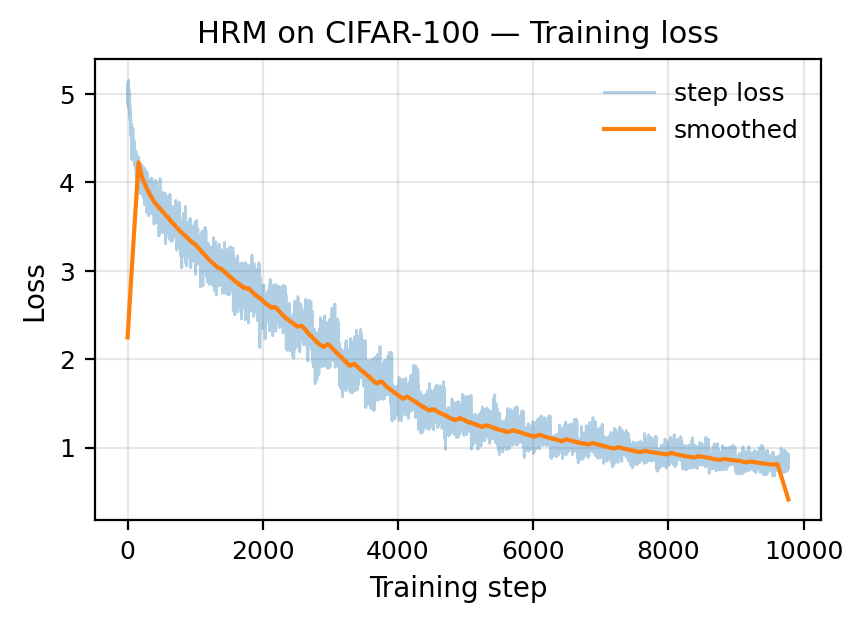

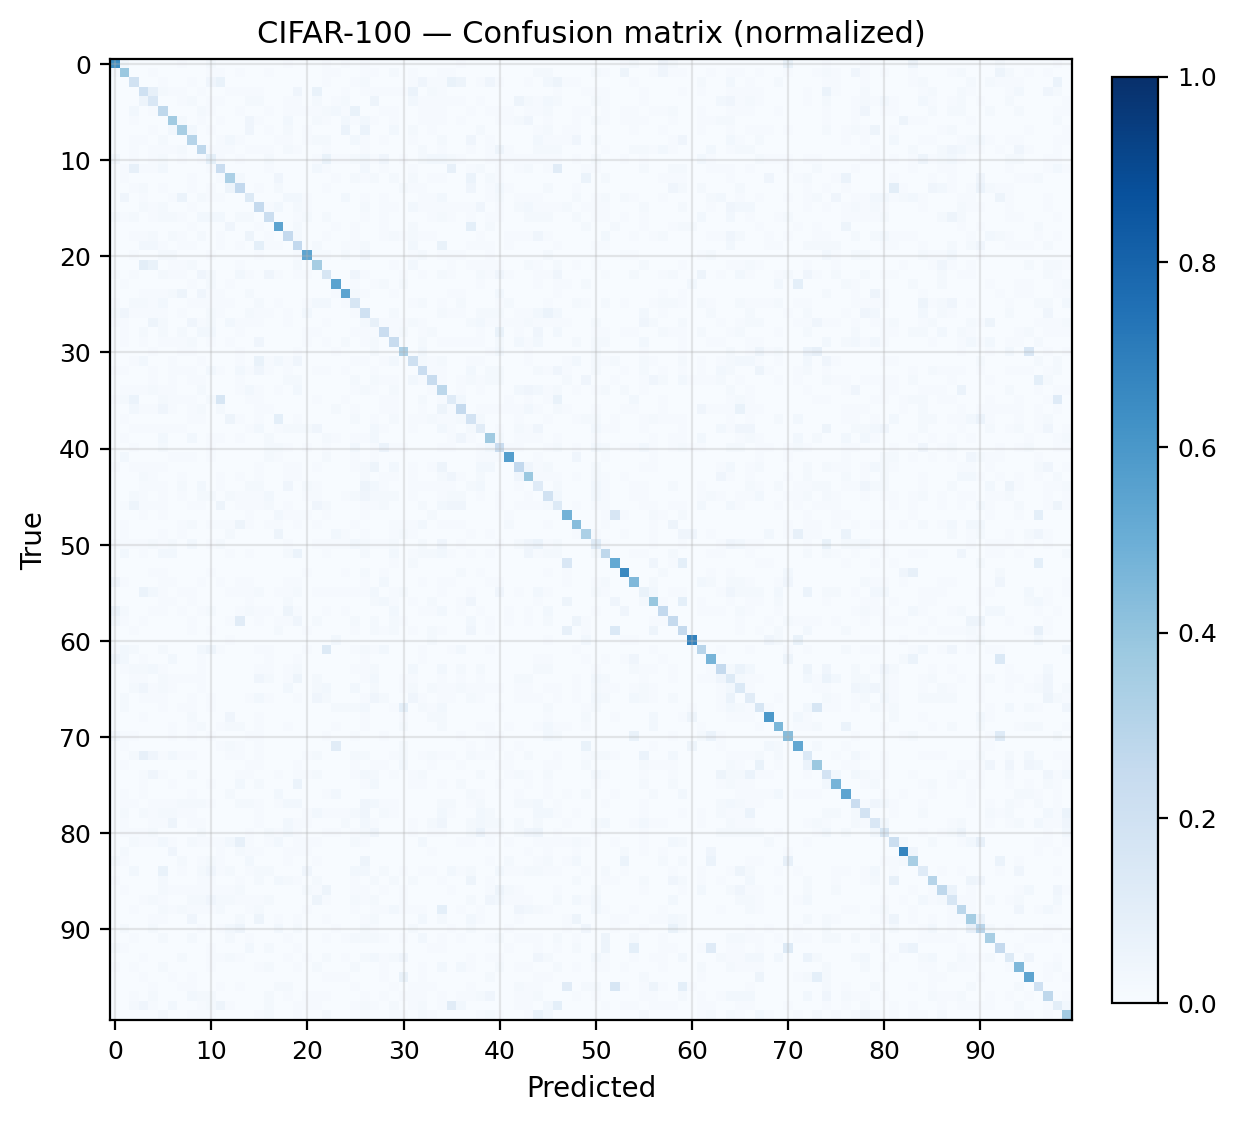

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3009255..2.024546].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7500879..1.1103902].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6832346..1.5798019].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8234335..2.024546].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4691415..0.9776357].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.88211..1.655325].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6067728..1.

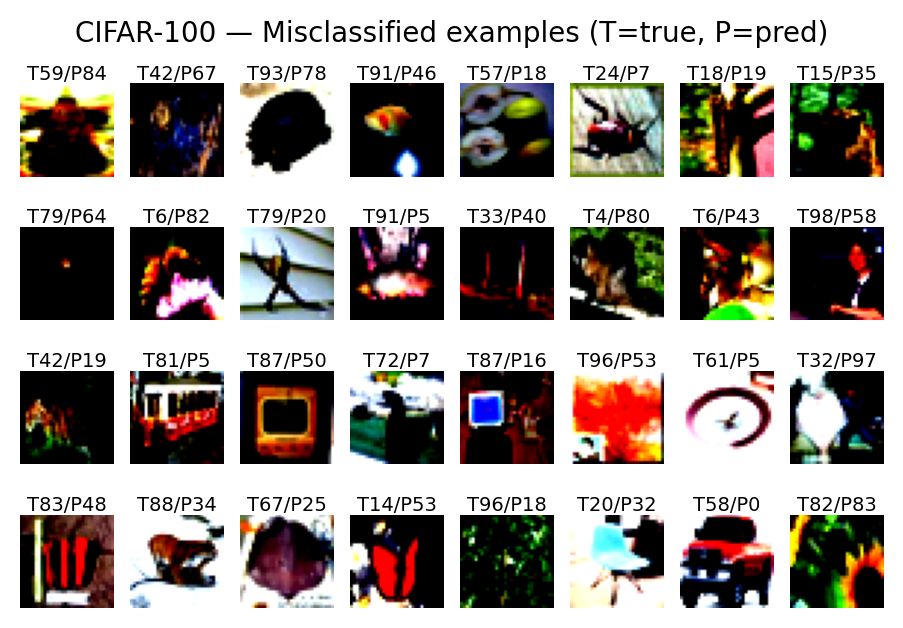

[cifar100_hrm_D192_H2_L3_seg2_seed2468] Params=3,569,856, Test acc=29.70%
Saved figures to: results/cifar100_hrm_D192_H2_L3_seg2_seed2468


In [ ]:

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

#  moving-average smooth 
def smooth_c100(y, k=21):
    if k <= 1 or k > len(y): return y
    w = np.ones(k) / k
    return np.convolve(y, w, mode="same")

# 1) Training loss curve
fig, ax = plt.subplots(figsize=(4.2, 3.0), constrained_layout=True)
ax.plot(step_loss_c100, lw=1.0, alpha=0.35, label="step loss")
ax.plot(smooth_c100(step_loss_c100, k=max(11, len(step_loss_c100)//30)), lw=1.5, label="smoothed")
ax.set_xlabel("Training step")
ax.set_ylabel("Loss")
ax.set_title("HRM on CIFAR-100 — Training loss", pad=6)
ax.legend(loc="best", frameon=False)
fig.savefig(RUN_DIR_C100 / "loss_curve.pdf", bbox_inches="tight")
fig.savefig(RUN_DIR_C100 / "loss_curve.png", bbox_inches="tight")
plt.show()

# 
y_true_c100, y_pred_c100 = [], []
test_it = batch_iterator(x_test_c100, y_test_c100, cfg_c100.batch_size, shuffle=False, seed=0)
for xb, yb in test_it:
    bsz = xb.shape[0]
    z_pair = (tile_state(z0H_t_c100, bsz), tile_state(z0L_t_c100, bsz))
    logits = None
    for _ in range(cfg_c100.num_segments_eval):
        (z_pair, logits) = model_c100.apply(
            {"params": params_c100},
            xb, z_pair,
            cfg_c100.num_high_cycles, cfg_c100.num_low_steps_per_cycle,
            False, False
        )
        z_pair = (jax.lax.stop_gradient(z_pair[0]), jax.lax.stop_gradient(z_pair[1]))
    y_true_c100.append(np.asarray(yb))
    y_pred_c100.append(np.asarray(jnp.argmax(logits, axis=-1)))

y_true_c100 = np.concatenate(y_true_c100)
y_pred_c100 = np.concatenate(y_pred_c100)

cm_c100 = confusion_matrix(y_true_c100, y_pred_c100, labels=np.arange(cfg_c100.num_classes))
cm_norm_c100 = cm_c100 / cm_c100.sum(axis=1, keepdims=True)
np.save(RUN_DIR_C100 / "confusion_matrix.npy", cm_c100)

fig, ax = plt.subplots(figsize=(6.0, 5.5), constrained_layout=True)
im = ax.imshow(cm_norm_c100, interpolation="nearest", cmap="Blues", vmin=0.0, vmax=1.0)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
# sparsify ticks every 10 classes to keep labels readable
tick_step = 10
ax.set_xticks(np.arange(0, cfg_c100.num_classes, tick_step))
ax.set_yticks(np.arange(0, cfg_c100.num_classes, tick_step))
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("CIFAR-100 — Confusion matrix (normalized)", pad=6)
fig.savefig(RUN_DIR_C100 / "confusion_matrix.pdf", bbox_inches="tight")
fig.savefig(RUN_DIR_C100 / "confusion_matrix.png", bbox_inches="tight")
plt.show()


mis_idx = np.where(y_true_c100 != y_pred_c100)[0]
np.random.default_rng(cfg_c100.seed).shuffle(mis_idx)
mis_idx = mis_idx[:32]

if mis_idx.size > 0:
    cols = 8
    rows = int(np.ceil(len(mis_idx) / cols))
    fig, axes = plt.subplots(
        rows, cols,
        figsize=(4.4, 0.55 * rows + 0.9),
        constrained_layout=True
    )
    if rows == 1:
        axes = np.array([axes])
    for ax in axes.ravel(): 
        ax.axis("off")

    for i, idx in enumerate(mis_idx):
        r, c = divmod(i, cols)
        ax = axes[r, c]
        ax.imshow(x_test_c100[idx])
        ax.axis("off")
        ax.set_title(f"T{int(y_true_c100[idx])}/P{int(y_pred_c100[idx])}", fontsize=7, pad=1.5)

    fig.suptitle("CIFAR-100 — Misclassified examples (T=true, P=pred)", fontsize=10)
    fig.savefig(RUN_DIR_C100 / "errors_grid.pdf", bbox_inches="tight", pad_inches=0.03)
    fig.savefig(RUN_DIR_C100 / "errors_grid.png", bbox_inches="tight", pad_inches=0.03)
    plt.show()

print(f"[{RUN_NAME_C100}] Params={count_params(params_c100):,}, Test acc={test_acc_c100*100:.2f}%")
print("Saved figures to:", RUN_DIR_C100)


In [ ]:

print(f"CIFAR-100 final test accuracy: {test_acc_c100:.4f}")
print(f"CIFAR-100 total parameters: {count_params(params_c100):,}")
for r in epoch_rows_c100:
    print(f"Epoch {r['epoch']:02d}  train_loss={r['train_loss']:.4f}  train_acc={r['train_acc']:.4f}")


CIFAR-100 final test accuracy: 0.2970
CIFAR-100 total parameters: 3,569,856
Epoch 01  train_loss=4.1566  train_acc=0.0775
Epoch 02  train_loss=3.6121  train_acc=0.1608
Epoch 03  train_loss=3.3055  train_acc=0.2250
Epoch 04  train_loss=3.0275  train_acc=0.2874
Epoch 05  train_loss=2.8019  train_acc=0.3411
Epoch 06  train_loss=2.5868  train_acc=0.3912
Epoch 07  train_loss=2.3675  train_acc=0.4454
Epoch 08  train_loss=2.1545  train_acc=0.5003
Epoch 09  train_loss=1.9344  train_acc=0.5598
Epoch 10  train_loss=1.7348  train_acc=0.6189
Epoch 11  train_loss=1.5607  train_acc=0.6692
Epoch 12  train_loss=1.4249  train_acc=0.7141
Epoch 13  train_loss=1.3195  train_acc=0.7443
Epoch 14  train_loss=1.2399  train_acc=0.7710
Epoch 15  train_loss=1.1840  train_acc=0.7875
Epoch 16  train_loss=1.1350  train_acc=0.8035
Epoch 17  train_loss=1.0823  train_acc=0.8200
Epoch 18  train_loss=1.0400  train_acc=0.8350
Epoch 19  train_loss=0.9941  train_acc=0.8512
Epoch 20  train_loss=0.9570  train_acc=0.8629
Epoc

# CIFAR 100 Conv net

In [ ]:

from dataclasses import dataclass
import jax, jax.numpy as jnp
import numpy as np
from tqdm import tqdm
import flax, flax.linen as nn
import optax
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd

#
try:
    x_train_c100
    y_train_c100
    x_test_c100
    y_test_c100
    c100_mean, c100_std
except NameError:
    #
    (x_train_c100, y_train_c100), (x_test_c100, y_test_c100) = load_cifar100()
    (x_train_c100, (c100_mean, c100_std)) = standardize_per_channel(x_train_c100)
    (x_test_c100,  _) = standardize_per_channel(x_test_c100, mean=c100_mean, std=c100_std)

#
try:
    CNNConfig
except NameError:
    @dataclass
    class CNNConfig:
        dataset_name: str = "cifar100"
        image_shape: tuple = (32, 32, 3)
        num_classes: int = 100
        # Model
        base_width: int = 64
        dropout_rate: float = 0.0
        # Optimization
        learning_rate: float = 3e-4
        weight_decay: float = 5e-4
        batch_size: int = 128
        num_epochs: int = 25
        seed: int = 2026
        label_smoothing: float = 0.05
        # LR schedule
        warmup_epochs: int = 1
        floor_ratio: float = 0.20


cfg_cnn_c100 = CNNConfig(
    dataset_name="cifar100",
    image_shape=(32, 32, 3),
    num_classes=100,
    base_width=64,         
    dropout_rate=0.0, 
    learning_rate=3e-4,
    weight_decay=5e-4,
    batch_size=128,
    num_epochs=25,
    seed=2026,
    label_smoothing=0.05,
    warmup_epochs=1,
    floor_ratio=0.20,
)


mpl.rcParams.update({
    "figure.figsize": (3.8, 2.7),
    "figure.dpi": 200,
    "savefig.dpi": 300,
    "font.size": 10,
    "axes.titlesize": 11,
    "axes.labelsize": 10,
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "axes.grid": True,
    "grid.alpha": 0.3,
})
mpl.rcParams['figure.constrained_layout.use'] = True

RUN_NAME_C100_CNN = f"cifar100_cnn_W{cfg_cnn_c100.base_width}_seed{cfg_cnn_c100.seed}"
RUN_DIR_C100_CNN = Path("./results") / RUN_NAME_C100_CNN
RUN_DIR_C100_CNN.mkdir(parents=True, exist_ok=True)

steps_per_epoch_cnn_c100 = (len(x_train_c100) + cfg_cnn_c100.batch_size - 1) // cfg_cnn_c100.batch_size
keygen_cnn_c100 = split_key(cfg_cnn_c100.seed)


In [ ]:

class SmallCNN(nn.Module):
    num_classes: int
    base_width: int = 64
    dropout_rate: float = 0.0

    @nn.compact
    def __call__(self, x: jnp.ndarray, training: bool) -> jnp.ndarray:
        # Block 1: 32x32 -> 16x16
        x = nn.Conv(self.base_width, (3, 3), padding="SAME", use_bias=False)(x)
        x = nn.BatchNorm(use_running_average=not training, momentum=0.9, epsilon=1e-5)(x)
        x = nn.relu(x)
        x = nn.Conv(self.base_width, (3, 3), padding="SAME", use_bias=False)(x)
        x = nn.BatchNorm(use_running_average=not training, momentum=0.9, epsilon=1e-5)(x)
        x = nn.relu(x)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2), padding="VALID")  # 16x16

        # Block 2: 16x16 -> 8x8
        x = nn.Conv(self.base_width * 2, (3, 3), padding="SAME", use_bias=False)(x)
        x = nn.BatchNorm(use_running_average=not training, momentum=0.9, epsilon=1e-5)(x)
        x = nn.relu(x)
        x = nn.Conv(self.base_width * 2, (3, 3), padding="SAME", use_bias=False)(x)
        x = nn.BatchNorm(use_running_average=not training, momentum=0.9, epsilon=1e-5)(x)
        x = nn.relu(x)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2), padding="VALID")  # 8x8

        #  head
        if self.dropout_rate > 0.0:
            x = nn.Dropout(self.dropout_rate)(x, deterministic=not training)
        x = jnp.mean(x, axis=(1, 2))  # global average pooling
        logits = nn.Dense(self.num_classes, use_bias=False)(x)
        return logits


In [ ]:

def make_optimizer_with_warmup_floor_for_cnn(cfg, steps_per_epoch: int, mask=None):
    total_steps = steps_per_epoch * cfg.num_epochs
    warmup_steps = steps_per_epoch * cfg.warmup_epochs

    warmup = optax.linear_schedule(init_value=0.0,
                                   end_value=cfg.learning_rate,
                                   transition_steps=warmup_steps)
    cosine = optax.cosine_decay_schedule(init_value=cfg.learning_rate,
                                         decay_steps=total_steps,
                                         alpha=cfg.floor_ratio)
    lr_schedule = optax.join_schedules([warmup, cosine], boundaries=[warmup_steps])

    tx = optax.chain(
        optax.clip_by_global_norm(1.0),
        optax.adamw(learning_rate=lr_schedule, weight_decay=cfg.weight_decay, mask=mask)
    )
    return tx


USE_DECAY_MASK_C100 = False

def make_decay_mask_for_cnn(params):
    from flax.traverse_util import flatten_dict, unflatten_dict
    flat = flatten_dict(params, sep='/')
    mask_flat = {}
    for k, v in flat.items():
        name = k
        if name.endswith('/bias') or name.endswith('/scale') or 'BatchNorm' in name or v.ndim < 2:
            mask_flat[k] = False
        else:
            mask_flat[k] = True
    return unflatten_dict(mask_flat, sep='/')


In [64]:
# %% [code]
# Build and initialize the CNN for CIFAR-100
model_cnn_c100 = SmallCNN(num_classes=cfg_cnn_c100.num_classes,
                          base_width=cfg_cnn_c100.base_width,
                          dropout_rate=cfg_cnn_c100.dropout_rate)

dummy_c100 = jnp.zeros((1,) + cfg_cnn_c100.image_shape, dtype=jnp.float32)
variables_cnn_c100 = model_cnn_c100.init(next(keygen_cnn_c100), dummy_c100, training=True)
params_cnn_c100 = variables_cnn_c100["params"]
batch_stats_cnn_c100 = variables_cnn_c100.get("batch_stats", {})

# Optimizer
decay_mask_c100 = make_decay_mask_for_cnn(params_cnn_c100) if USE_DECAY_MASK_C100 else None
optimizer_cnn_c100 = make_optimizer_with_warmup_floor_for_cnn(cfg_cnn_c100, steps_per_epoch_cnn_c100, mask=decay_mask_c100)
opt_state_cnn_c100 = optimizer_cnn_c100.init(params_cnn_c100)

print("CIFAR-100 CNN parameter count:", count_params(params_cnn_c100))


CIFAR-100 CNN parameter count: 273344


In [ ]:

def label_smoothed_ce(logits: jnp.ndarray, labels: jnp.ndarray, num_classes: int, epsilon: float) -> jnp.ndarray:
    one_hot = jax.nn.one_hot(labels, num_classes=num_classes)
    smoothed = (1.0 - epsilon) * one_hot + (epsilon / num_classes)
    log_probs = jax.nn.log_softmax(logits, axis=-1)
    return -(smoothed * log_probs).sum(axis=-1).mean()

def accuracy_from_logits(logits: jnp.ndarray, labels: jnp.ndarray) -> jnp.ndarray:
    return (jnp.argmax(logits, axis=-1) == labels).mean()

@jax.jit
def train_step_cnn_c100(params, batch_stats, opt_state, images, labels):
    def loss_fn(p, bstats):
        variables = {"params": p, "batch_stats": bstats}
        logits, new_state = model_cnn_c100.apply(variables, images, training=True, mutable=["batch_stats"])
        loss = label_smoothed_ce(logits, labels, cfg_cnn_c100.num_classes, cfg_cnn_c100.label_smoothing)
        acc  = accuracy_from_logits(logits, labels)
        return loss, (new_state["batch_stats"], acc)

    (loss, (new_batch_stats, acc)), grads = jax.value_and_grad(loss_fn, has_aux=True)(params, batch_stats)
    updates, opt_state = optimizer_cnn_c100.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, new_batch_stats, opt_state, loss, acc

@jax.jit
def eval_logits_cnn_c100(params, batch_stats, images):
    variables = {"params": params, "batch_stats": batch_stats}
    logits = model_cnn_c100.apply(variables, images, training=False, mutable=False)
    return logits

def evaluate_cnn_c100(params, batch_stats, x, y, batch_size: int) -> float:
    it = batch_iterator(x, y, batch_size, shuffle=False, seed=0)
    total_correct = 0
    total = 0
    for xb, yb in it:
        logits = eval_logits_cnn_c100(params, batch_stats, xb)
        preds = np.asarray(jnp.argmax(logits, axis=-1))
        y_true = np.asarray(yb)
        total_correct += int((preds == y_true).sum())
        total += int(preds.size)
    return total_correct / total


In [ ]:

step_loss_c100_cnn = []
step_acc_c100_cnn  = []
epoch_train_acc_c100_cnn = []
epoch_test_acc_c100_cnn  = []

for epoch in range(1, cfg_cnn_c100.num_epochs + 1):
    it = batch_iterator(x_train_c100, y_train_c100, cfg_cnn_c100.batch_size, shuffle=True, seed=cfg_cnn_c100.seed + epoch)
    running_loss = 0.0
    running_acc  = 0.0
    n_batches = 0

    for xb, yb in tqdm(it, total=steps_per_epoch_cnn_c100, desc=f"[CNN-C100] Epoch {epoch}"):
        params_cnn_c100, batch_stats_cnn_c100, opt_state_cnn_c100, loss_b, acc_b = train_step_cnn_c100(
            params_cnn_c100, batch_stats_cnn_c100, opt_state_cnn_c100, xb, yb
        )
        loss_b, acc_b = float(loss_b), float(acc_b)
        step_loss_c100_cnn.append(loss_b)
        step_acc_c100_cnn.append(acc_b)
        running_loss += loss_b
        running_acc  += acc_b
        n_batches += 1

    train_acc_epoch = running_acc / n_batches
    epoch_train_acc_c100_cnn.append(train_acc_epoch)

    test_acc_epoch = evaluate_cnn_c100(params_cnn_c100, batch_stats_cnn_c100, x_test_c100, y_test_c100, cfg_cnn_c100.batch_size)
    epoch_test_acc_c100_cnn.append(float(test_acc_epoch))

    print(f"[CNN-C100] Epoch {epoch:02d} | train loss {running_loss/n_batches:.4f} | "
          f"train acc {train_acc_epoch:.4f} | test acc {test_acc_epoch:.4f}")

final_test_acc_c100_cnn = epoch_test_acc_c100_cnn[-1]
print(f"[CNN-C100] Final test accuracy: {final_test_acc_c100_cnn:.4f}")
print(f"[CNN-C100] Total parameters: {count_params(params_cnn_c100):,}")


[CNN-C100] Epoch 1: 100%|██████████| 391/391 [00:17<00:00, 22.92it/s]


[CNN-C100] Epoch 01 | train loss 4.3328 | train acc 0.0699 | test acc 0.1251


[CNN-C100] Epoch 2: 100%|██████████| 391/391 [00:11<00:00, 32.63it/s]


[CNN-C100] Epoch 02 | train loss 3.7284 | train acc 0.1716 | test acc 0.1983


[CNN-C100] Epoch 3: 100%|██████████| 391/391 [00:12<00:00, 30.83it/s]


[CNN-C100] Epoch 03 | train loss 3.4390 | train acc 0.2235 | test acc 0.2321


[CNN-C100] Epoch 4: 100%|██████████| 391/391 [00:12<00:00, 31.04it/s]


[CNN-C100] Epoch 04 | train loss 3.2569 | train acc 0.2602 | test acc 0.2611


[CNN-C100] Epoch 5: 100%|██████████| 391/391 [00:12<00:00, 30.97it/s]


[CNN-C100] Epoch 05 | train loss 3.1153 | train acc 0.2893 | test acc 0.2820


[CNN-C100] Epoch 6: 100%|██████████| 391/391 [00:12<00:00, 30.91it/s]


[CNN-C100] Epoch 06 | train loss 3.0067 | train acc 0.3092 | test acc 0.3015


[CNN-C100] Epoch 7: 100%|██████████| 391/391 [00:12<00:00, 30.91it/s]


[CNN-C100] Epoch 07 | train loss 2.9101 | train acc 0.3312 | test acc 0.3241


[CNN-C100] Epoch 8: 100%|██████████| 391/391 [00:12<00:00, 30.90it/s]


[CNN-C100] Epoch 08 | train loss 2.8263 | train acc 0.3504 | test acc 0.3349


[CNN-C100] Epoch 9: 100%|██████████| 391/391 [00:12<00:00, 31.07it/s]


[CNN-C100] Epoch 09 | train loss 2.7510 | train acc 0.3696 | test acc 0.3447


[CNN-C100] Epoch 10: 100%|██████████| 391/391 [00:12<00:00, 31.09it/s]


[CNN-C100] Epoch 10 | train loss 2.6848 | train acc 0.3837 | test acc 0.3528


[CNN-C100] Epoch 11: 100%|██████████| 391/391 [00:12<00:00, 30.98it/s]


[CNN-C100] Epoch 11 | train loss 2.6281 | train acc 0.3963 | test acc 0.3742


[CNN-C100] Epoch 12: 100%|██████████| 391/391 [00:12<00:00, 30.99it/s]


[CNN-C100] Epoch 12 | train loss 2.5725 | train acc 0.4107 | test acc 0.3860


[CNN-C100] Epoch 13: 100%|██████████| 391/391 [00:12<00:00, 31.20it/s]


[CNN-C100] Epoch 13 | train loss 2.5295 | train acc 0.4231 | test acc 0.3862


[CNN-C100] Epoch 14: 100%|██████████| 391/391 [00:12<00:00, 31.13it/s]


[CNN-C100] Epoch 14 | train loss 2.4834 | train acc 0.4334 | test acc 0.4049


[CNN-C100] Epoch 15: 100%|██████████| 391/391 [00:12<00:00, 31.10it/s]


[CNN-C100] Epoch 15 | train loss 2.4448 | train acc 0.4434 | test acc 0.4146


[CNN-C100] Epoch 16: 100%|██████████| 391/391 [00:12<00:00, 31.21it/s]


[CNN-C100] Epoch 16 | train loss 2.4083 | train acc 0.4512 | test acc 0.4182


[CNN-C100] Epoch 17: 100%|██████████| 391/391 [00:12<00:00, 31.00it/s]


[CNN-C100] Epoch 17 | train loss 2.3797 | train acc 0.4617 | test acc 0.4228


[CNN-C100] Epoch 18: 100%|██████████| 391/391 [00:12<00:00, 31.22it/s]


[CNN-C100] Epoch 18 | train loss 2.3511 | train acc 0.4690 | test acc 0.4297


[CNN-C100] Epoch 19: 100%|██████████| 391/391 [00:12<00:00, 31.10it/s]


[CNN-C100] Epoch 19 | train loss 2.3265 | train acc 0.4772 | test acc 0.4352


[CNN-C100] Epoch 20: 100%|██████████| 391/391 [00:12<00:00, 31.01it/s]


[CNN-C100] Epoch 20 | train loss 2.3030 | train acc 0.4824 | test acc 0.4410


[CNN-C100] Epoch 21: 100%|██████████| 391/391 [00:12<00:00, 31.07it/s]


[CNN-C100] Epoch 21 | train loss 2.2834 | train acc 0.4885 | test acc 0.4465


[CNN-C100] Epoch 22: 100%|██████████| 391/391 [00:12<00:00, 31.10it/s]


[CNN-C100] Epoch 22 | train loss 2.2654 | train acc 0.4920 | test acc 0.4486


[CNN-C100] Epoch 23: 100%|██████████| 391/391 [00:12<00:00, 30.96it/s]


[CNN-C100] Epoch 23 | train loss 2.2504 | train acc 0.4987 | test acc 0.4585


[CNN-C100] Epoch 24: 100%|██████████| 391/391 [00:12<00:00, 31.05it/s]


[CNN-C100] Epoch 24 | train loss 2.2340 | train acc 0.5039 | test acc 0.4572


[CNN-C100] Epoch 25: 100%|██████████| 391/391 [00:12<00:00, 31.08it/s]


[CNN-C100] Epoch 25 | train loss 2.2234 | train acc 0.5045 | test acc 0.4528
[CNN-C100] Final test accuracy: 0.4528
[CNN-C100] Total parameters: 273,344


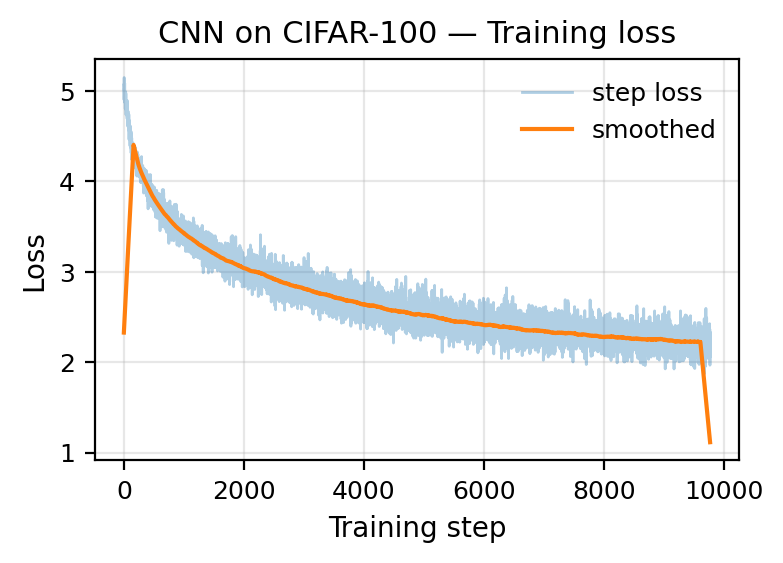

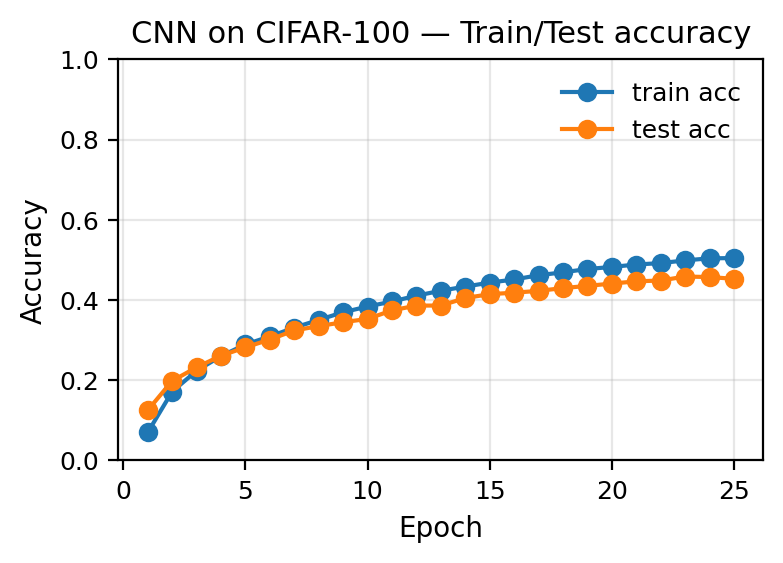

In [ ]:

def smooth_trace(y, k=21):
    if k <= 1 or k > len(y): 
        return y
    w = np.ones(k) / k
    return np.convolve(np.asarray(y), w, mode="same")


fig, ax = plt.subplots(figsize=(3.8, 2.7), constrained_layout=True)
ax.plot(step_loss_c100_cnn, lw=1.0, alpha=0.35, label="step loss")
ax.plot(smooth_trace(step_loss_c100_cnn, k=max(11, len(step_loss_c100_cnn)//30)), lw=1.5, label="smoothed")
ax.set_xlabel("Training step")
ax.set_ylabel("Loss")
ax.set_title("CNN on CIFAR-100 — Training loss", pad=6)
ax.legend(loc="best", frameon=False)
fig.savefig(RUN_DIR_C100_CNN / "loss_curve.pdf", bbox_inches="tight")
fig.savefig(RUN_DIR_C100_CNN / "loss_curve.png", bbox_inches="tight")
plt.show()


epochs = np.arange(1, cfg_cnn_c100.num_epochs + 1)
fig, ax = plt.subplots(figsize=(3.8, 2.7), constrained_layout=True)
ax.plot(epochs, epoch_train_acc_c100_cnn, marker='o', lw=1.5, label="train acc")
ax.plot(epochs, epoch_test_acc_c100_cnn, marker='o', lw=1.5, label="test acc")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.set_ylim(0.0, 1.0)
ax.set_title("CNN on CIFAR-100 - Train/Test accuracy", pad=6)
ax.legend(loc="best", frameon=False)
fig.savefig(RUN_DIR_C100_CNN / "accuracy_curves.pdf", bbox_inches="tight")
fig.savefig(RUN_DIR_C100_CNN / "accuracy_curves.png", bbox_inches="tight")
plt.show()


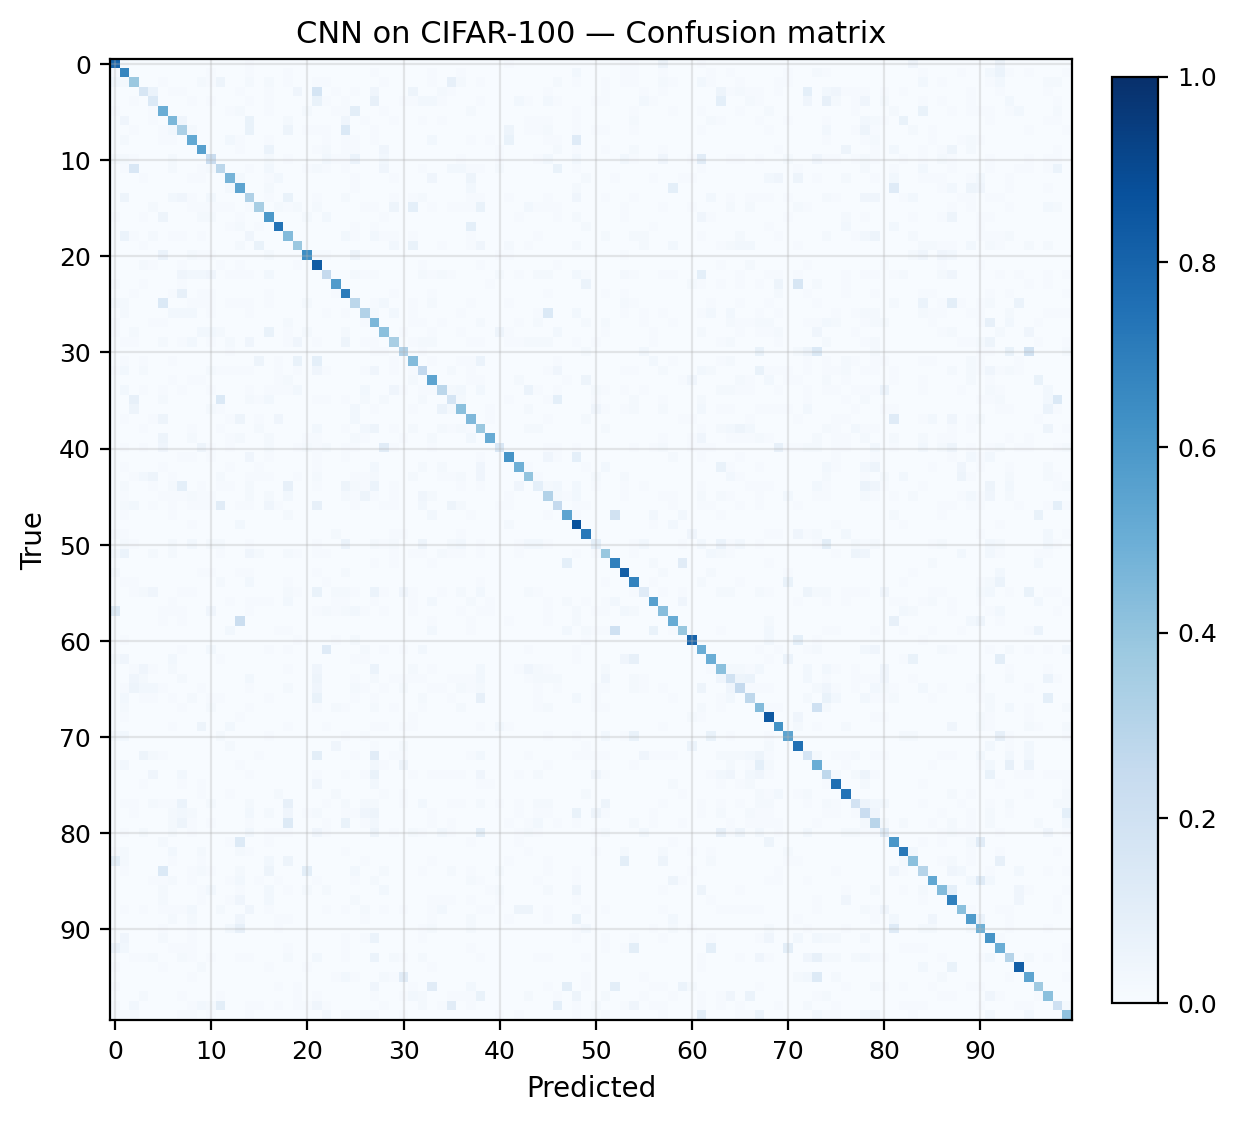

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7060806..1.375237].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3926797..1.7269611].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6526498..2.024546].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4997263..1.1984049].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7138193..1.7851696].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8514504..2.024546].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8973275..

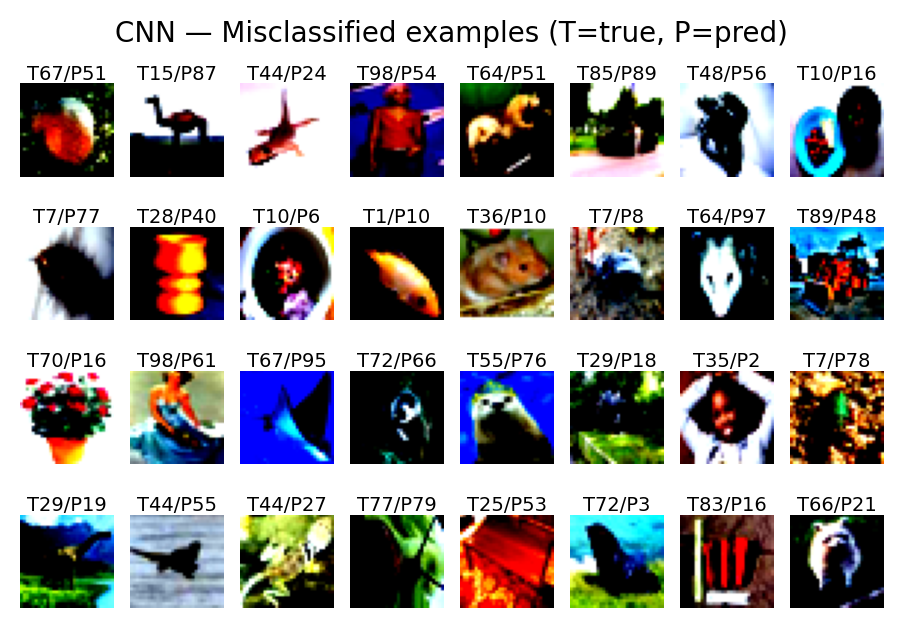

[cifar100_cnn_W64_seed2026] Params=273,344, Final Test acc=45.28%
Saved figures to: results/cifar100_cnn_W64_seed2026


In [ ]:

y_true_c100_cnn, y_pred_c100_cnn = [], []
it_test = batch_iterator(x_test_c100, y_test_c100, cfg_cnn_c100.batch_size, shuffle=False, seed=0)
for xb, yb in it_test:
    logits = eval_logits_cnn_c100(params_cnn_c100, batch_stats_cnn_c100, xb)
    y_true_c100_cnn.append(np.asarray(yb))
    y_pred_c100_cnn.append(np.asarray(jnp.argmax(logits, axis=-1)))

y_true_c100_cnn = np.concatenate(y_true_c100_cnn)
y_pred_c100_cnn = np.concatenate(y_pred_c100_cnn)

cm_c100_cnn = confusion_matrix(y_true_c100_cnn, y_pred_c100_cnn, labels=np.arange(cfg_cnn_c100.num_classes))
cm_norm_c100_cnn = cm_c100_cnn / cm_c100_cnn.sum(axis=1, keepdims=True)
np.save(RUN_DIR_C100_CNN / "confusion_matrix.npy", cm_c100_cnn)


fig, ax = plt.subplots(figsize=(6.0, 5.5), constrained_layout=True)
im = ax.imshow(cm_norm_c100_cnn, interpolation="nearest", cmap="Blues", vmin=0.0, vmax=1.0)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
tick_step = 10
ax.set_xticks(np.arange(0, cfg_cnn_c100.num_classes, tick_step))
ax.set_yticks(np.arange(0, cfg_cnn_c100.num_classes, tick_step))
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("CNN on CIFAR-100 - Confusion matrix", pad=6)
fig.savefig(RUN_DIR_C100_CNN / "confusion_matrix.pdf", bbox_inches="tight")
fig.savefig(RUN_DIR_C100_CNN / "confusion_matrix.png", bbox_inches="tight")
plt.show()

# Misclassified grid (up to 32 examples)
mis_idx = np.where(y_true_c100_cnn != y_pred_c100_cnn)[0]
np.random.default_rng(cfg_cnn_c100.seed).shuffle(mis_idx)
mis_idx = mis_idx[:32]

if mis_idx.size > 0:
    cols = 8
    rows = int(np.ceil(len(mis_idx) / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(4.4, 0.55 * rows + 0.9), constrained_layout=True)
    if rows == 1:
        axes = np.array([axes])
    for ax in axes.ravel():
        ax.axis("off")
    for i, idx in enumerate(mis_idx):
        r, c = divmod(i, cols)
        ax = axes[r, c]
        ax.imshow(x_test_c100[idx])
        ax.axis("off")
        ax.set_title(f"T{int(y_true_c100_cnn[idx])}/P{int(y_pred_c100_cnn[idx])}", fontsize=7, pad=1.5)

    fig.suptitle("CNN — Misclassified examples (T=true, P=pred)", fontsize=10)
    fig.savefig(RUN_DIR_C100_CNN / "errors_grid.pdf", bbox_inches="tight", pad_inches=0.03)
    fig.savefig(RUN_DIR_C100_CNN / "errors_grid.png", bbox_inches="tight")
    plt.show()

print(f"[{RUN_NAME_C100_CNN}] Params={count_params(params_cnn_c100):,}, Final Test acc={final_test_acc_c100_cnn*100:.2f}%")
print("Saved figures to:", RUN_DIR_C100_CNN)


In [ ]:

np.savez(
    RUN_DIR_C100_CNN / "metrics.npz",
    step_loss=np.array(step_loss_c100_cnn, np.float32),
    step_acc=np.array(step_acc_c100_cnn, np.float32),
    epoch=np.arange(1, cfg_cnn_c100.num_epochs + 1),
    epoch_train_acc=np.array(epoch_train_acc_c100_cnn, np.float32),
    epoch_test_acc=np.array(epoch_test_acc_c100_cnn, np.float32),
    n_params=np.int64(count_params(params_cnn_c100)),
)

pd.DataFrame({
    "epoch": np.arange(1, cfg_cnn_c100.num_epochs + 1),
    "train_acc": epoch_train_acc_c100_cnn,
    "test_acc": epoch_test_acc_c100_cnn
}).to_csv(RUN_DIR_C100_CNN / "epoch_metrics.csv", index=False)
